# 08MIAR - Aprendizaje Por Refuerzo: Proyecto de programación "*Entrenamiento Agente Para Space Invaders*"



---


##### Autores:    Daniel Romero Martinez / Roberto Vazquez Calvo / Pere Marc Monserrat Calbo
##### Fecha:      Enero 2026.
##### Titulación: Master Universitario en Inteligencia Artificial - VIU
##### Profesor:   D. Jose Manuel Camacho

---



---
# 0. Enunciado del Problema

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga **alcanzar más de 20 puntos con reward clipping durante más de 100 episodios consecutivos**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
# 1. Instalación y preparacion del entorno
Todo el codigo que prepara el entorno en base a si estamos en Colab o en Local se ha llevado a una funcion ejecutable para mantener el notebook mas limpio.

In [1]:
# Llamamos a funcion que prepara el entorno.
!python entorno_spaceinvadersv0.py


Estamos en entorno Local: /home/danielr/Repos/spaceInvaders-v0/.venv/bin/python
Directorio actual: /home/danielr/Repos/spaceInvaders-v0
Archivos en el directorio:
['Solucion3', '.python-version', 'Solucion1', '08MIAR_Proyecto_Programacion_G21_Dani.ipynb', 'draft', 'env_functions.py', 'entorno_spaceinvadersv0.py', '__pycache__', '08MIAR_Proyecto_Programacion_G21.ipynb', 'Anexo_MEMORIA.md', '.venv', '.gitignore', '.git', 'Solucion2', 'img']

La version de Python instalada en este entorno Local es: 3.8

Comprobando Paquetes Instalados....

✔ numpy ya está instalado.
✔ Keras ya está instalado.
✔ keras-rl2 ya está instalado.
✔ tensorflow ya está instalado.
✔ gym ya está instalado.
✔ atari_py ya está instalado.
✔ pyglet ya está instalado.
✔ h5py ya está instalado.
✔ Pillow ya está instalado.
✔ opencv-python-headless ya está instalado.
✔ matplotlib ya está instalado.

El entorno esta listo.


---
# 2. Desarrollo y preguntas

## 2.1 Declaraciones Generales

In [6]:
# Llamada a funciones generales
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Layer, Permute

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory, Memory

from IPython.display import display, Markdown

# Llamada a funciones propias
from env_functions import plot_rewards, agent_eval, ShowLastTraining, merge_json_logs
from env_functions import set_seeds, make_env, AtariProcessor, TrainAgent, TestAgent
import env_functions as ef

# Anulamos UserWarnings de TensorFlow
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

## 2.2 Solución nº1 - DQN
En esta solucion implementamos una arquitectura basada en DQN básico.
<p align="center">
  <img src="img/Single_DQN_img.png" width="600">
</p>

La red Deep Q‑Network (DQN) combina el aprendizaje por refuerzo con redes neuronales profundas para aproximar la función de valor Q, permitiendo que un agente aprenda políticas directamente a partir de imágenes del entorno. La arquitectura recibe como entrada una secuencia de frames preprocesados y genera como salida un valor Q para cada acción posible. Al tratarse de un algoritmo off‑policy, el agente emplea experience replay para almacenar transiciones pasadas y reutilizarlas mediante muestreo aleatorio, reduciendo la correlación entre muestras. Además, se utiliza una target network para estabilizar las actualizaciones de los valores Q, lo que permite un aprendizaje más robusto y consistente en entornos complejos como los juegos Atari.


#### 2.2.1 Configuración base

In [4]:
# Definicion de parametros fijos y carga de los entornos de training & test.
# Parametros fijos
seed = 42
Memory_Size = 500000
N_Solucion = 1
Reward_min = 20
Episodios_min = 100
Training_Steps = 1500000

# Definimos la semilla para la reproducibilidad de la ejecución
set_seeds(seed)

# Cargamos entornos de simulacion
env_tr = make_env(seed, training=True)
env_te = make_env(seed, training=False)

# Extraemos informacion sobre las acciones y el espacio de observacion del entorno
nb_actions = env_tr.action_space.n
height, width, channels = env_tr.observation_space.shape

print(f"Numero de acciones del juego: {nb_actions}")
print(
    f"Tipo de acciones disponibles en el juego: {env_tr.unwrapped.get_action_meanings()}"
)
print(f"Dimensiones del Frame del juego: [{height},{width},{channels}]")

Numero de acciones del juego: 6
Tipo de acciones disponibles en el juego: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del Frame del juego: [210,160,3]


#### 2.2.2 Implementación de la red neuronal

In [5]:
# Definimos la arquitectura de red neuronal en una funcion, asi podemos llamarla directamente y pasarle los parametros que vamos a evaluar.
def BuildDcnn(n_classes=6):
    model = Sequential(name="DQN_CNN")
    # Entrada
    model.add(Permute((2, 3, 1), input_shape=(ef.WINDOW_LENGTH,) + ef.INPUT_SHAPE))

    # Base Model - Bloque convolucional
    model.add(
        Conv2D(
            16, (8, 8), strides=(4, 4), padding="valid", activation="relu", name="conv1"
        )
    )
    model.add(
        Conv2D(
            32, (4, 4), strides=(2, 2), padding="valid", activation="relu", name="conv2"
        )
    )
    model.add(
        Conv2D(
            32, (3, 3), strides=(1, 1), padding="valid", activation="relu", name="conv3"
        )
    )

    # Top Model - Capa FC.
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation="relu", name="fc_shared"))

    # Capa final: Q(s,a)
    model.add(Dense(n_classes, activation="linear", name="Q_values"))

    return model


# mostramos datos entrada
print("Tamaño de la imagen de entrada:", ef.IM_SHAPE)
print("Numero de clases/acciones:", nb_actions)

# Llamamos a la funcion de construccion de la red del modelo. Esta red neuronal: recibe el estado s, produce vector con los valores Q(s,a), en este caso
# tendremos un vector con 6 componentes (6 acciones). La red evalua cual es la mejor Q(s,a).
model = BuildDcnn(nb_actions)

# Mostramos la arquitectura de la red declarada
model.summary()

Tamaño de la imagen de entrada: (84, 84, 4)
Numero de clases/acciones: 6
Model: "DQN_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 9, 32)          8224      
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
fc_shared (Dense)            (None, 128)               200832    
____________________________________________________

#### 2.2.3 Implementación de la solución DQN

In [7]:
# Definimos nuestro agente: Buffer memoria, policy y tipo agente.
def BuildAgent(model, memory_size, tr_steps, n_actions, lr=0.0005):

    # Preparación de la memoria (usamos memory replay en DQN).
    ReplayBuffer = SequentialMemory(limit=memory_size, window_length=ef.WINDOW_LENGTH)

    # Llamamos a clase para pre-procesado de las observaciones.
    processor = AtariProcessor()

    # Definimos la policy, estrategia para seleccionar las acciones. Decide que accion tomar.
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),  # Estrategia E-greedy.
        attr="eps",
        value_max=1.0,  # Explora totalmente al inicio
        value_min=0.05,  # Explora poco al final del entrenamiento
        value_test=0.05,  # Exploración mínima en test
        nb_steps=tr_steps,  # Duración del decaimiento
    )

    # Definición del agente DQN. Aqui se junta todo, es el cerebro que coordina todo.
    # Llama a la ANN para estimar la Q, aplica la policy para elegir la acción, interactua con el entorno y usa el replay bufer para guardar las experiencias,
    # entrena la red mediante el target network para estabilizar el aprendizaje y la actualiza con la función de perdidas.
    dqn = DQNAgent(
        model=model,  # La red CNN que estima la distribución Q
        nb_actions=n_actions,  # Número de acciones posibles en el entorno
        memory=ReplayBuffer,  # Replay buffer para almacenar transiciones
        policy=policy,  # Política/Estrategia
        processor=processor,  # Preprocesado de observaciones
        nb_steps_warmup=50000,  # Pasos iniciales solo explorando (sin entrenar)
        target_model_update=10000,  # Frecuencia de actualización del target network
        train_interval=4,  # Entrenar cada X pasos de interacción
        gamma=0.99,  # Factor de descuento para recompensas futuras
    )

    # Compilación del agente
    dqn.compile(Adam(learning_rate=lr, clipnorm=10.0), metrics=["mae"])

    # Mostrar confirmacion
    print("Agente creado con exito.")

    return dqn


# Construimos el agente.
agent = BuildAgent(model, Memory_Size, Training_Steps, nb_actions, 0.00025)

Agente creado con exito.


#### 2.2.4 Entrenamiento del Agente DQN
Configuramos y ejecutamos el entrenamiento del agente. Se realiza un entrenamiento en 3 etapas, con diferente numero de steps e hiperparametros del agente en cada una de ellas. Al final de este a apartado se analizan los resultados.

##### 2.2.4.1 Etapa 1: Entrenamiento desde 0 con 1.5M steps

Cargando pesos: Solucion1/dqn1_SpaceInvaders-v0_weights_final_1.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 861s 9ms/step - reward: 3.4221
1713 episodes - episode_reward: 3.422 [0.000, 24.000] - loss: 0.029 - mae: 0.719 - mean_q: 0.900 - mean_eps: 0.952
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 1541s 15ms/step - reward: 3.9398
1628 episodes - episode_reward: 3.940 [0.000, 23.000] - loss: 0.041 - mae: 1.514 - mean_q: 1.899 - mean_eps: 0.906
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 1686s 17ms/step - reward: 4.6947
1474 episodes - episode_reward: 4.695 [0.000, 28.000] - loss: 0.074 - mae: 2.711 - mean_q: 3.364 - mean_eps: 0.842
---

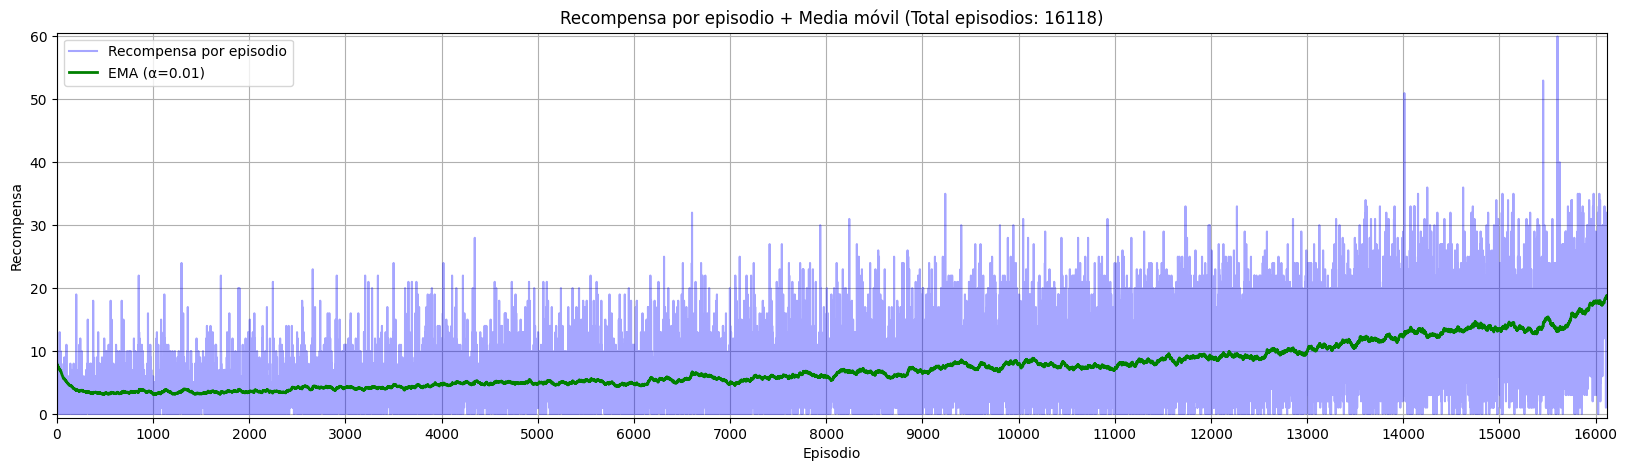

In [8]:
# Entrenamos agente.
n_tr = 1
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_1.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 27.63 | Máximo: 54.00 | Mínimo: 18.00
Objetivo no alcanzado: Se han obtenido 91 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




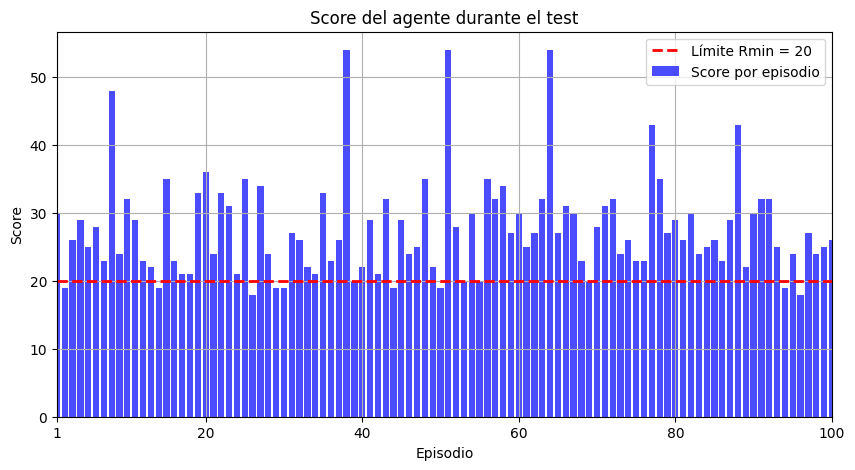

In [12]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.2.4.2 Etapa 2: Fine Tuning de 750k steps

Cargando pesos: Solucion1/dqn1_SpaceInvaders-v0_weights_final_2.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 1104s 11ms/step - reward: 19.5992
499 episodes - episode_reward: 19.599 [0.000, 36.000] - loss: 0.290 - mae: 10.627 - mean_q: 12.991 - mean_eps: 0.045
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 1988s 20ms/step - reward: 20.2639
485 episodes - episode_reward: 20.264 [0.000, 43.000] - loss: 0.256 - mae: 10.630 - mean_q: 12.973 - mean_eps: 0.039
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 1954s 20ms/step - reward: 20.5431
499 episodes - episode_reward: 20.543 [0.000, 40.000] - loss: 0.275 - mae: 10.583 - mean_q: 12.917 - mean_eps

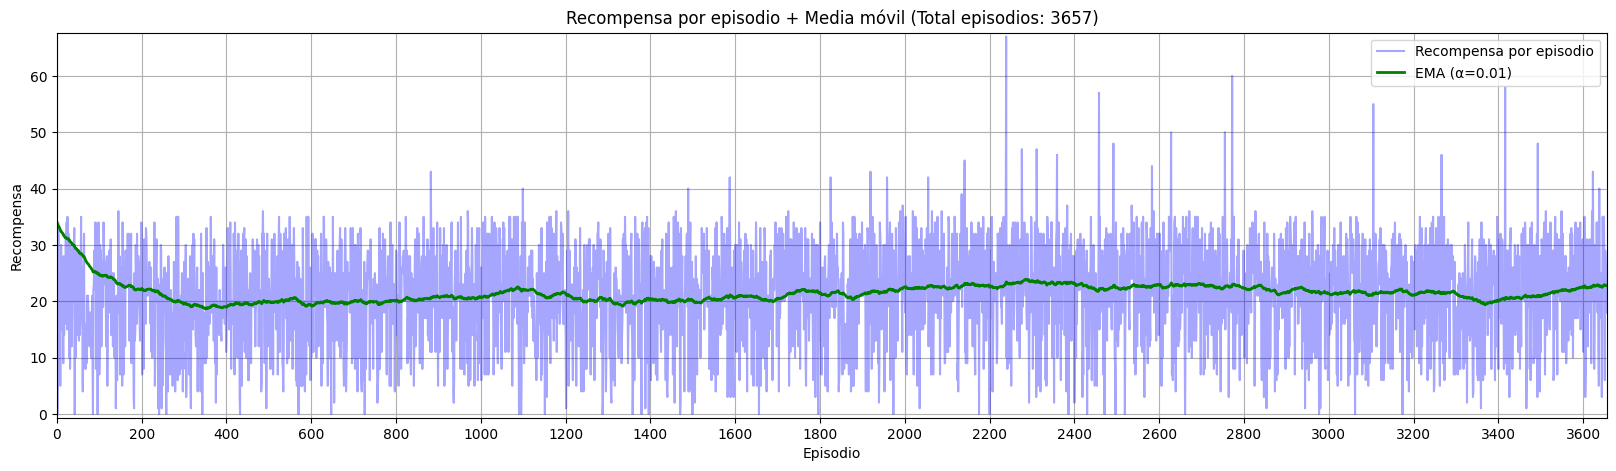

In [10]:
# Fijamos steps.
n_tr = 2
Training_Steps = 750000
decay_steps = int(Training_Steps * 0.75)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.000015
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.05,  # Continua donde lo habia dejado
    value_min=0.01,  # termina casi determinista (1% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_2.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 33.24 | Máximo: 71.00 | Mínimo: 9.00
Objetivo no alcanzado: Se han obtenido 95 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




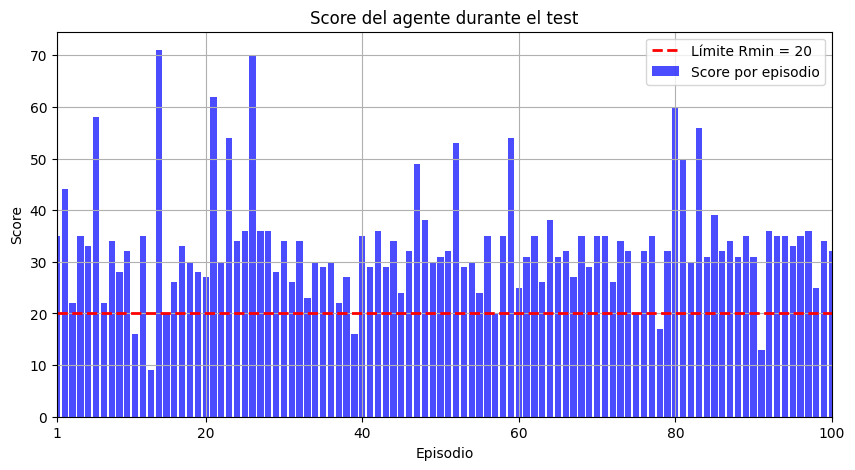

In [14]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.2.4.3 Etapa 3: Entrenamiento final de 500k steps adicionales

Cargando pesos: Solucion1/dqn1_SpaceInvaders-v0_weights_final_3.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 1077s 11ms/step - reward: 19.3509
530 episodes - episode_reward: 19.351 [0.000, 53.000] - loss: 0.210 - mae: 10.127 - mean_q: 12.294 - mean_eps: 0.082
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2015s 20ms/step - reward: 20.3505
525 episodes - episode_reward: 20.350 [0.000, 36.000] - loss: 0.231 - mae: 10.169 - mean_q: 12.364 - mean_eps: 0.065
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 1981s 20ms/step - reward: 22.4661
472 episodes - episode_reward: 22.466 [0.000, 70.000] - loss: 0.213 - mae: 10.198 - mean_q: 12.398 - mean_eps

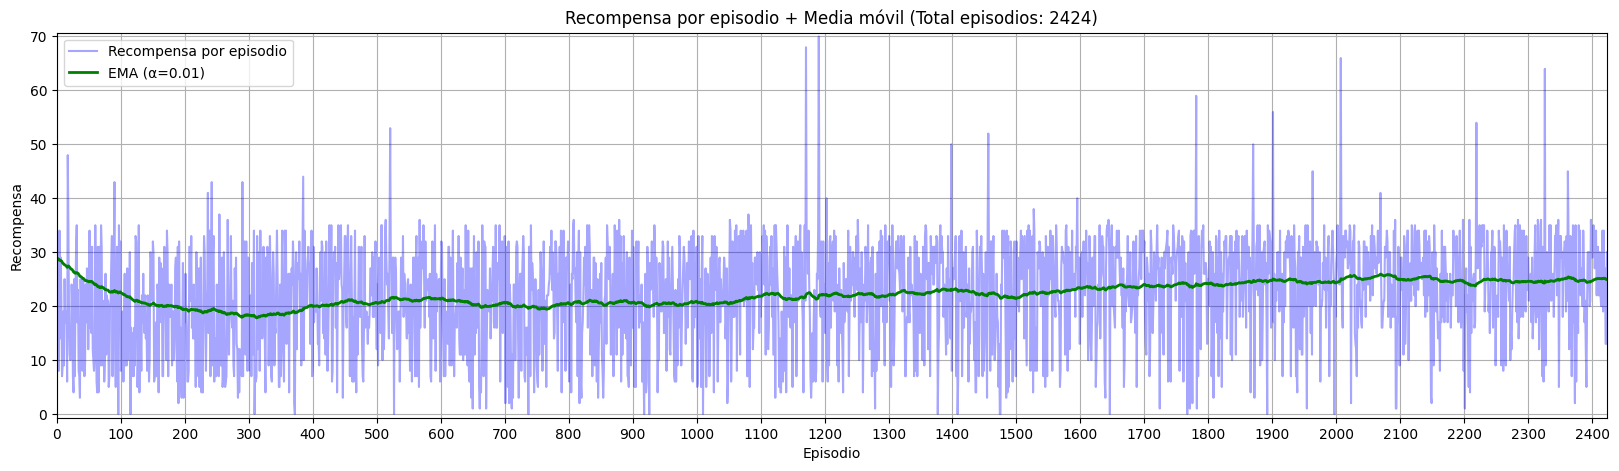

In [11]:
# Fijamos steps.
n_tr = 3
Training_Steps = 500000
decay_steps = int(Training_Steps * 0.80)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.00001
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Subimos el epsilon final de la etapa anterior para permitir exploracion de nuevo (10%) y bajamos a 0.005 con el 80% de los steps.
# El 20% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.10,  # Explora de nuevo un 10% nuevo
    value_min=0.005,  # termina casi determinista (0.5% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 36.36 | Máximo: 71.00 | Mínimo: 23.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




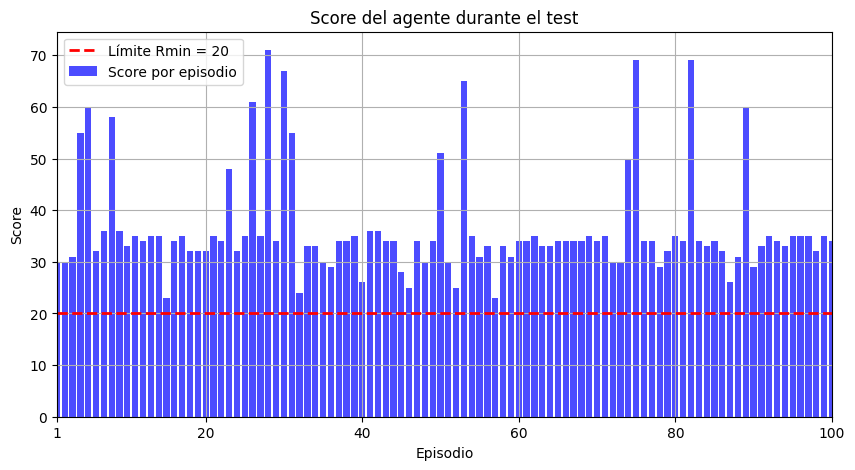

In [18]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

#### 2.2.5 Justificación de los parámetros seleccionados y de los resultados obtenidos

---

JSON combinado guardado en: Solucion1/dqn1_SpaceInvaders-v0_log_FULL.json
Total episodios combinados: 22199


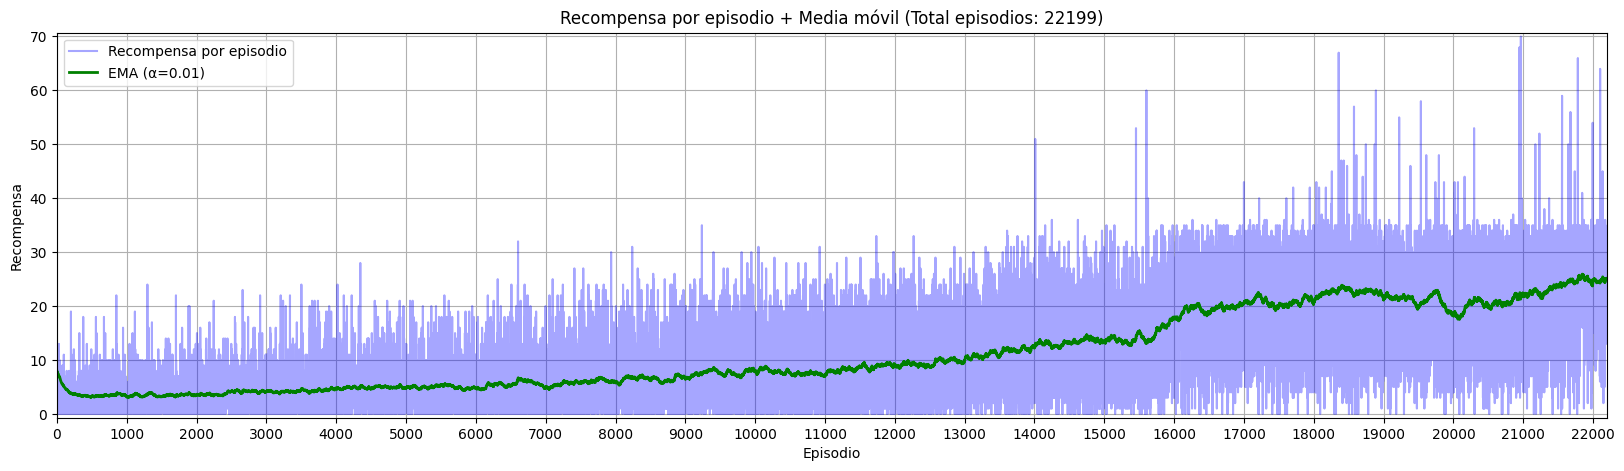

In [12]:
# Graficamos evolución de las 3 fases del entrenamiento
json_paths = [
    "Solucion1/dqn1_SpaceInvaders-v0_log_1.json",
    "Solucion1/dqn1_SpaceInvaders-v0_log_2.json",
    "Solucion1/dqn1_SpaceInvaders-v0_log_3.json",
]

merge_json_logs(json_paths, "Solucion1/dqn1_SpaceInvaders-v0_log_FULL.json")

plot_rewards("Solucion1/dqn1_SpaceInvaders-v0_log_FULL.json", 0.01)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 300 episodios...
  Episodio 300/300
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 300
Resultados Test (reward): Media: 34.17 | Máximo: 72.00 | Mínimo: 21.00
Objetivo superado: Durante 300 episodios consecutivos se ha superado o igualado los 20 puntos.




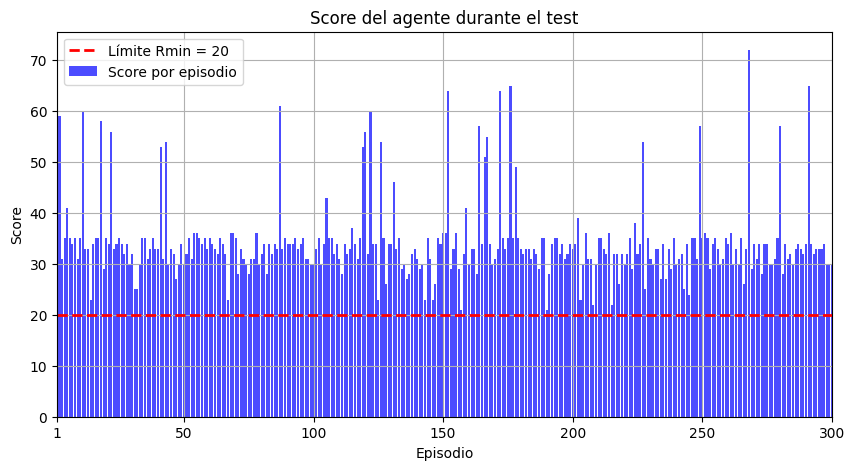

In [20]:
# Test de performance del agente durante 300 episodios
n_test = 300
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

Se ha realizado un entrenamiento por etapas:
- Etapa1: Inicialmente se optó por entrenar el modelo con 1.5M de steps. A la vista de los resultados mostrados en la curva de entrenamiento, se identificó que el modelo mantenia una pendiente ascendente en el reward medio por lo que todavia tenia margen de mejora. Se ha utilizado un learning rate de 0.00025 y una estrategia E-greedy con decaimiento progresivo desde 1 a 0.05. La red target se actualiza cada 10k steps.
- Etapa2: Se optó por una fase de ajuste fino de 750k steps adicionales para maximizar la política de explotación. Se ha utilizado un learning rate de 0.000015 y una estrategia E-greedy con decaimiento progresivo desde 0.05 a 0.01 para el 75% de los steps dejando el 25% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps para dar más estabilidad al aprendizaje y ayudar a que el error de los valores Q no oscile tanto.
- Etapa3: En vista a los resultados de la etapa anterior, se decide hacer una ultima etapa adicional de 500k steps. Se ha utilizado un learning rate de 0.00001 y una estrategia E-greedy con decaimiento progresivo desde 0.1 a 0.005 para el 80% de los steps dejando el 20% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps igual que en la etapa anterior.

Resultados:
- Tras 1.5M steps de entrenamiento, el test del agente ha dado un resultado de 91/100 episodios por encima de 20 puntos y una media de 27.6 puntos, lo cual no está nada mal. El aprendizaje del agente ha ido mejorando progresivamente a lo largo de los 1.5M steps.
- Tras hacer un fine tunning de 750K steps adicionales el test del agente ha dado un resultado de 95/100 episodios por encima de 20 puntos y la media ha sido de 33.2 puntos. El agente ha mejorado claramente en esta 2ª etapa.
- Finalmente tras 500k steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 36.3 puntos. El agente ha mejorado claramente en esta 3ª etapa final hasta superar el reto.
- Ejecutamos un test adicional de 300 episodios para ver comportamiento mas amplio. El resultado es de 300/300 episodios por encima de 20 puntos y la media ha sido de 34.17 puntos.
- Analizando la curva completa de entrenamiento de 2.75M de steps, vemos que el agente ha tenido un progreso claro a través de las 3 etapas desarrolladas. 


## 2.3 Solución nº2 - Double DQN
En esta solucion implementamos una arquitectura doble DQN...
<p align="center">
  <img src="img/Double_DQN_img.png" width="600">
</p>

La aproximación Double DQN surge para solucionar el problema del sesgo de sobreestimación de los valores Q. Según esta aproximación se desacoplan los procesos de selección y evaluación de una acción. Según esta aproximación se utilizará la red online (la que se esta entrenando) para seleccionar la siguiente acción y después se utilizará la target (una copia desactualizada de la online) para evaluar la acción escogida y obtener su valor Q. Con esta aproximación se evita que un error positivo accidental en una de las redes se propague de forma global. Con esto se consigue un aprendizaje mucho mas estable y una convergencia hacía una policy óptima más rápida. 

#### 2.3.1 Configuración base

In [3]:
# Definicion de parametros fijos y carga de los entornos de training & test.
# Parametros fijos
seed = 42
Memory_Size = 500000
N_Solucion = 2
Reward_min = 20
Episodios_min = 100
Training_Steps = 1500000

# Definimos la semilla para la reproducibilidad de la ejecución
set_seeds(seed)

# Cargamos entornos de simulacion
env_tr = make_env(seed, training=True)
env_te = make_env(seed, training=False)

# Extraemos informacion sobre las acciones y el espacio de observacion del entorno
nb_actions = env_tr.action_space.n
height, width, channels = env_tr.observation_space.shape

print(f"Numero de acciones del juego: {nb_actions}")
print(
    f"Tipo de acciones disponibles en el juego: {env_tr.unwrapped.get_action_meanings()}"
)
print(f"Dimensiones del Frame del juego: [{height},{width},{channels}]")

Numero de acciones del juego: 6
Tipo de acciones disponibles en el juego: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del Frame del juego: [210,160,3]


#### 2.3.2 Implementación de la red neuronal

In [4]:
# Definimos la arquitectura de red neuronal en una funcion, asi podemos llamarla directamente y pasarle los parametros que vamos a evaluar.
def BuildDcnn(n_classes=6):
    model = Sequential(name="Double DQN_CNN")
    # Entrada
    model.add(Permute((2, 3, 1), input_shape=(ef.WINDOW_LENGTH,) + ef.INPUT_SHAPE))

    # Base Model - Bloque convolucional
    model.add(
        Conv2D(
            16, (8, 8), strides=(4, 4), padding="valid", activation="relu", name="conv1"
        )
    )
    model.add(
        Conv2D(
            32, (4, 4), strides=(2, 2), padding="valid", activation="relu", name="conv2"
        )
    )
    model.add(
        Conv2D(
            32, (3, 3), strides=(1, 1), padding="valid", activation="relu", name="conv3"
        )
    )

    # Top Model - Capa FC.
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation="relu", name="fc_shared"))

    # Capa final: Q(s,a)
    model.add(Dense(n_classes, activation="linear", name="Q_values"))

    return model


# mostramos datos entrada
print("Tamaño de la imagen de entrada:", ef.IM_SHAPE)
print("Numero de clases/acciones:", nb_actions)

# Llamamos a la funcion de construccion de la red del modelo. Esta red neuronal: recibe el estado s, produce vector con los valores Q(s,a), en este caso
# tendremos un vector con 6 componentes (6 acciones). La red evalua cual es la mejor Q(s,a).
model = BuildDcnn(nb_actions)

# Mostramos la arquitectura de la red declarada
model.summary()

Tamaño de la imagen de entrada: (84, 84, 4)
Numero de clases/acciones: 6
Model: "Double DQN_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv1 (Conv2D)              (None, 20, 20, 16)        4112      
                                                                 
 conv2 (Conv2D)              (None, 9, 9, 32)          8224      
                                                                 
 conv3 (Conv2D)              (None, 7, 7, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 fc_shared (Dense)           (None, 128)               200832    
                                             

#### 2.3.3 Implementación de la solución DQN

In [10]:
# Definimos nuestro agente: Buffer memoria, policy y tipo agente.
def BuildAgent(model, memory_size, tr_steps, n_actions, lr=0.0005):

    # Preparación de la memoria (usamos memory replay en DQN).
    ReplayBuffer = SequentialMemory(limit=memory_size, window_length=ef.WINDOW_LENGTH)

    # Llamamos a clase para pre-procesado de las observaciones.
    processor = AtariProcessor()

    # Definimos la policy, estrategia para seleccionar las acciones. Decide que accion tomar.
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),  # Estrategia E-greedy.
        attr="eps",
        value_max=1.0,  # Explora totalmente al inicio
        value_min=0.05,  # Explora poco al final del entrenamiento
        value_test=0.05,  # Exploración mínima en test
        nb_steps=tr_steps,  # Duración del decaimiento
    )

    # Definición del agente DQN. Aqui se junta todo, es el cerebro que coordina todo.
    # Llama a la ANN para estimar la Q, aplica la policy para elegir la acción, interactua con el entorno y usa el replay bufer para guardar las experiencias,
    # entrena la red mediante el target network para estabilizar el aprendizaje y la actualiza con la función de perdidas.
    dqn = DQNAgent(
        model=model,                # La red CNN que estima la distribución Q
        nb_actions=n_actions,       # Número de acciones posibles en el entorno
        memory=ReplayBuffer,        # Replay buffer para almacenar transiciones
        policy=policy,              # Política/Estrategia
        processor=processor,        # Preprocesado de observaciones
        nb_steps_warmup=20000,      # Pasos iniciales solo explorando (sin entrenar)
        target_model_update=10_000, # Copiamos los pesos de la Q online a la target cada 10_000 pasos 
        train_interval=4,           # Entrenar cada X pasos de interacción
        gamma=0.99,                 # Factor de descuento para recompensas futuras
        enable_double_dqn=True,     # Habilitamos la doble dqn
    )

    # Compilación del agente
    dqn.compile(Adam(learning_rate=lr, clipnorm=10.0), metrics=["mae"])

    # Mostrar confirmacion
    print("Agente creado con exito.")

    return dqn


# Construimos el agente.
agent = BuildAgent(model, Memory_Size, Training_Steps, nb_actions, 0.00025)

2026-01-03 13:49:30.784276: W tensorflow/c/c_api.cc:300] Operation '{name:'conv3_3/kernel/Assign' id:1558 op device:{requested: '', assigned: ''} def:{{{node conv3_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv3_3/kernel, conv3_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Agente creado con exito.


#### 2.3.4 Entrenamiento del Agente DQN
Configuramos y ejecutamos el entrenamiento del agente. Se realiza un entrenamiento en 3 etapas, con diferente numero de steps e hiperparametros del agente en cada una de ellas. Al final de este a apartado se analizan los resultados.

##### 2.3.4.1 Etapa 1: Entrenamiento desde 0 con 1.5M steps

No se encontraron pesos previos, entrenando desde cero...
Training for 1500000 steps ...
Interval 1 (0 steps performed)
     1/100000 [..............................] - ETA: 4:30:21 - reward: 0.0000e+00

/home/danielr/Repos/spaceInvaders-v0/.venv/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2026-01-03 13:49:47.577089: W tensorflow/c/c_api.cc:300] Operation '{name:'Q_values/BiasAdd' id:125 op device:{requested: '', assigned: ''} def:{{{node Q_values/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](Q_values/MatMul, Q_values/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2026-01-03 13:49:47.634966: W tensorflow/c/c_api.cc:300] Operation '{name:'total_5/Assign' id:1720 op device:{requested: '', assigned: ''} def:{{{node total_5/Assign}} = AssignVariableOp

 20004/100000 [=====>........................] - ETA: 7:42 - reward: 0.0588

2026-01-03 13:51:43.433416: W tensorflow/c/c_api.cc:300] Operation '{name:'Q_values_3/BiasAdd' id:1618 op device:{requested: '', assigned: ''} def:{{{node Q_values_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](Q_values_3/MatMul, Q_values_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2026-01-03 13:51:43.818899: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_9/AddN' id:1841 op device:{requested: '', assigned: ''} def:{{{node loss_9/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul, loss_9/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2026-01-03 1

100000/100000 [==============================] - 2694s 27ms/step - reward: 0.0597
1660 episodes - episode_reward: 3.592 [0.000, 21.000] - loss: 0.035 - mae: 1.044 - mean_q: 1.296 - mean_eps: 0.962 - ale.lives: 2.983

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 3334s 33ms/step - reward: 0.0635
1634 episodes - episode_reward: 3.888 [0.000, 25.000] - loss: 0.053 - mae: 1.866 - mean_q: 2.312 - mean_eps: 0.905 - ale.lives: 2.984

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 3910s 39ms/step - reward: 0.0676
1531 episodes - episode_reward: 4.415 [0.000, 24.000] - loss: 0.079 - mae: 2.666 - mean_q: 3.287 - mean_eps: 0.842 - ale.lives: 2.985

Interval 4 (300000 steps performed)
100000/100000 [==============================] - 4163s 42ms/step - reward: 0.0710
1415 episodes - episode_reward: 5.016 [0.000, 28.000] - loss: 0.099 - mae: 3.405 - mean_q: 4.202 - mean_eps: 0.778 - ale.lives: 2.986

Interval 5 (400000 steps

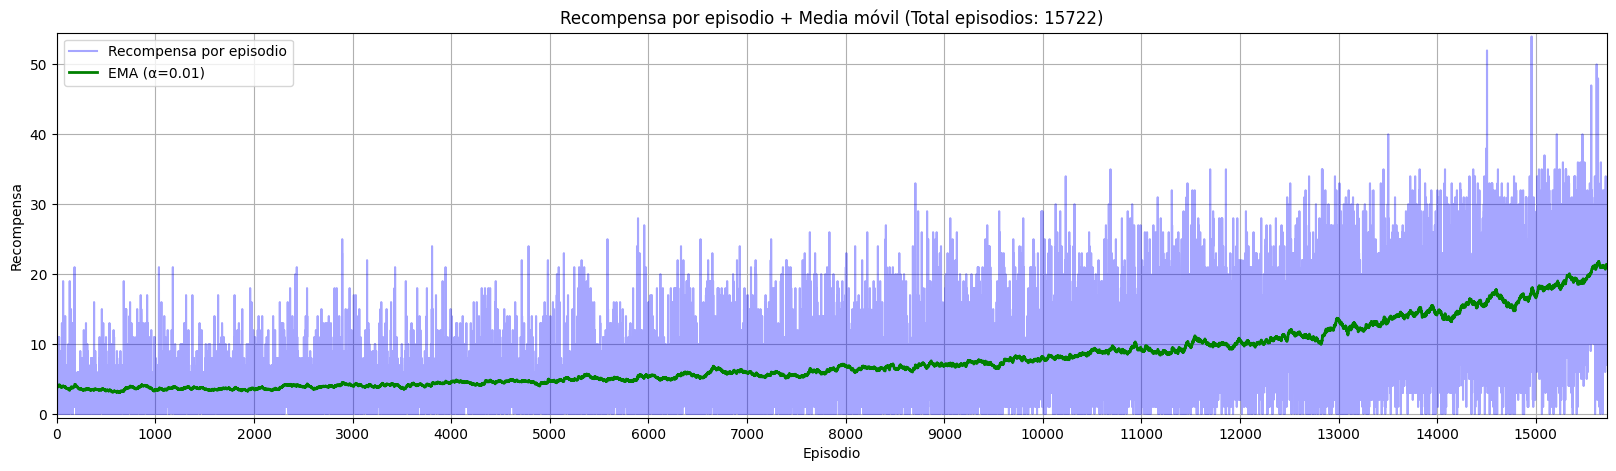

In [11]:
# Entrenamos agente.
n_tr = 1
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_1.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 31.70 | Máximo: 63.00 | Mínimo: 20.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




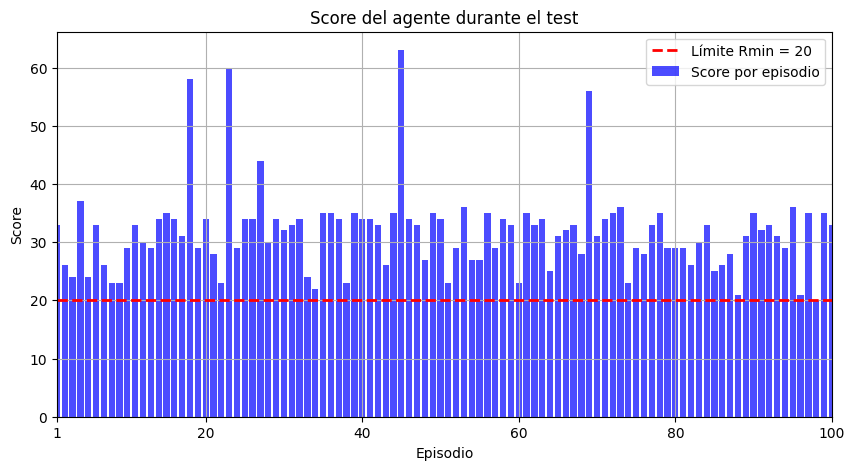

In [12]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.3.4.2 Etapa 2: Fine Tuning de 750k steps

No se encontraron pesos previos, entrenando desde cero...
Training for 750000 steps ...
Interval 1 (0 steps performed)
     1/100000 [..............................] - ETA: 18:10 - reward: 0.0000e+00

2026-01-04 10:17:01.987360: W tensorflow/c/c_api.cc:300] Operation '{name:'decay/Assign' id:2399 op device:{requested: '', assigned: ''} def:{{{node decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](decay, decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


100000/100000 [==============================] - 3383s 34ms/step - reward: 0.1096
523 episodes - episode_reward: 20.927 [0.000, 69.000] - loss: 0.138 - mae: 6.984 - mean_q: 8.526 - mean_eps: 0.046 - ale.lives: 2.993

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 4023s 40ms/step - reward: 0.1099
505 episodes - episode_reward: 21.786 [0.000, 65.000] - loss: 0.132 - mae: 6.944 - mean_q: 8.474 - mean_eps: 0.039 - ale.lives: 2.994

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 4229s 42ms/step - reward: 0.1132
506 episodes - episode_reward: 22.298 [0.000, 55.000] - loss: 0.134 - mae: 6.750 - mean_q: 8.241 - mean_eps: 0.032 - ale.lives: 2.993

Interval 4 (300000 steps performed)
100000/100000 [==============================] - 4296s 43ms/step - reward: 0.1109
491 episodes - episode_reward: 22.623 [0.000, 61.000] - loss: 0.124 - mae: 6.650 - mean_q: 8.112 - mean_eps: 0.025 - ale.lives: 2.993

Interval 5 (400000 steps

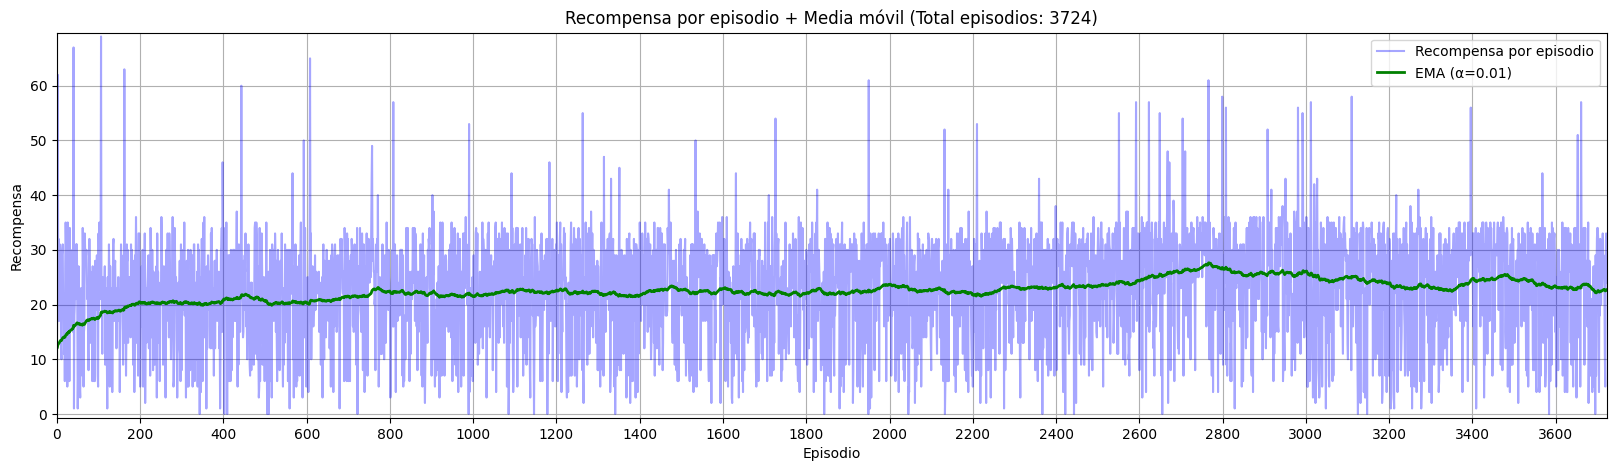

In [13]:
# Fijamos steps.
n_tr = 2
Training_Steps = 750000
decay_steps = int(Training_Steps * 0.75)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.000015
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.05,  # Continua donde lo habia dejado
    value_min=0.01,  # termina casi determinista (1% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_2.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 32.37 | Máximo: 61.00 | Mínimo: 18.00
Objetivo no alcanzado: Se han obtenido 97 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




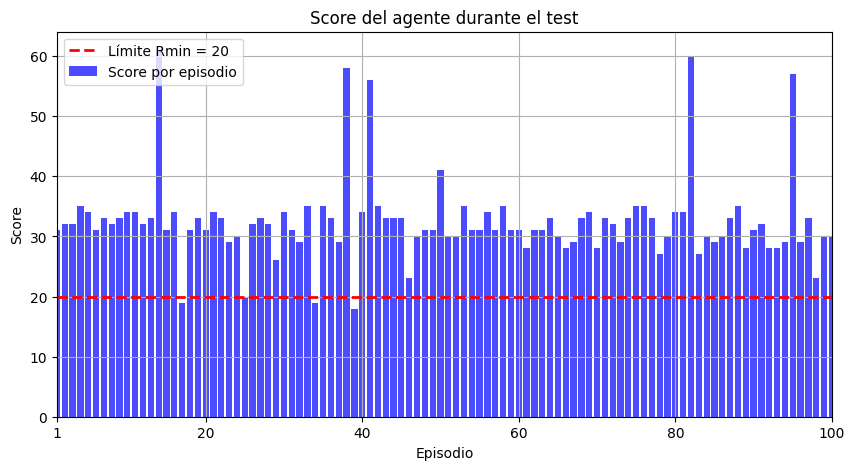

In [14]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.3.4.3 Etapa 3: Entrenamiento final de 500k steps adicionales

No se encontraron pesos previos, entrenando desde cero...
Training for 500000 steps ...
Interval 1 (0 steps performed)
100000/100000 [==============================] - 3409s 34ms/step - reward: 0.1160
552 episodes - episode_reward: 20.967 [0.000, 51.000] - loss: 0.133 - mae: 6.598 - mean_q: 8.043 - mean_eps: 0.086 - ale.lives: 2.993

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 4214s 42ms/step - reward: 0.1176
500 episodes - episode_reward: 23.550 [0.000, 56.000] - loss: 0.123 - mae: 6.626 - mean_q: 8.076 - mean_eps: 0.064 - ale.lives: 2.994

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 4149s 41ms/step - reward: 0.1198
480 episodes - episode_reward: 24.956 [0.000, 68.000] - loss: 0.123 - mae: 6.598 - mean_q: 8.043 - mean_eps: 0.041 - ale.lives: 2.994

Interval 4 (300000 steps performed)
100000/100000 [==============================] - 4173s 42ms/step - reward: 0.1242
499 episodes - episode_reward: 24.860 [0

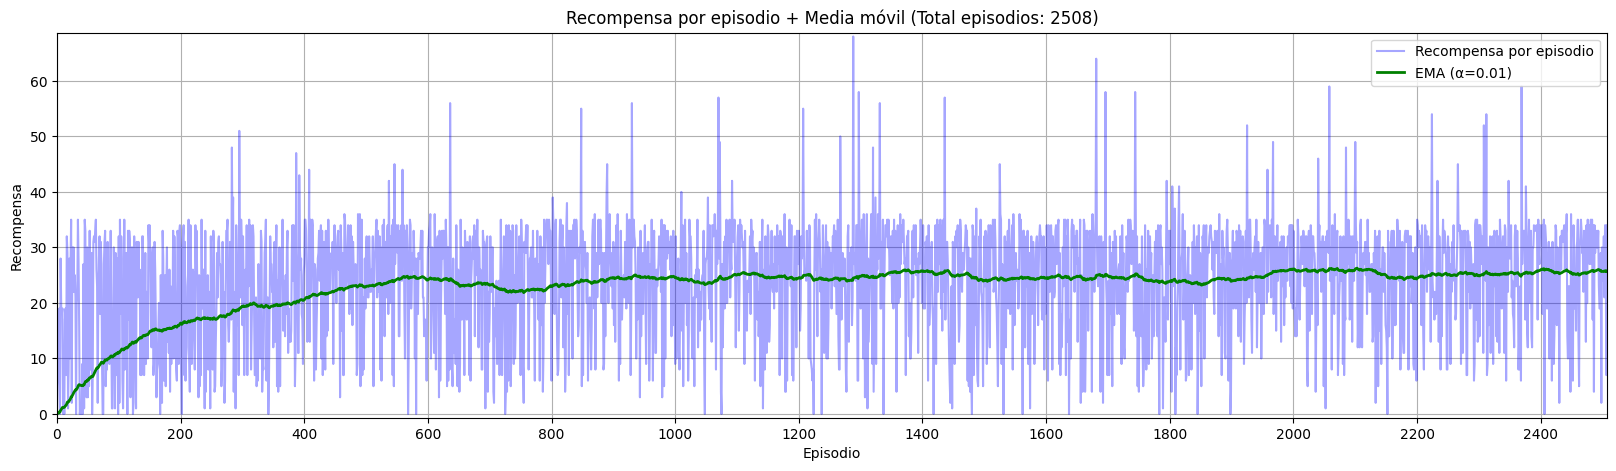

In [15]:
# Fijamos steps.
n_tr = 3
Training_Steps = 500000
decay_steps = int(Training_Steps * 0.80)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.00001
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Subimos el epsilon final de la etapa anterior para permitir exploracion de nuevo (10%) y bajamos a 0.005 con el 80% de los steps.
# El 20% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.10,  # Explora de nuevo un 10% nuevo
    value_min=0.005,  # termina casi determinista (0.5% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 34.80 | Máximo: 65.00 | Mínimo: 27.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




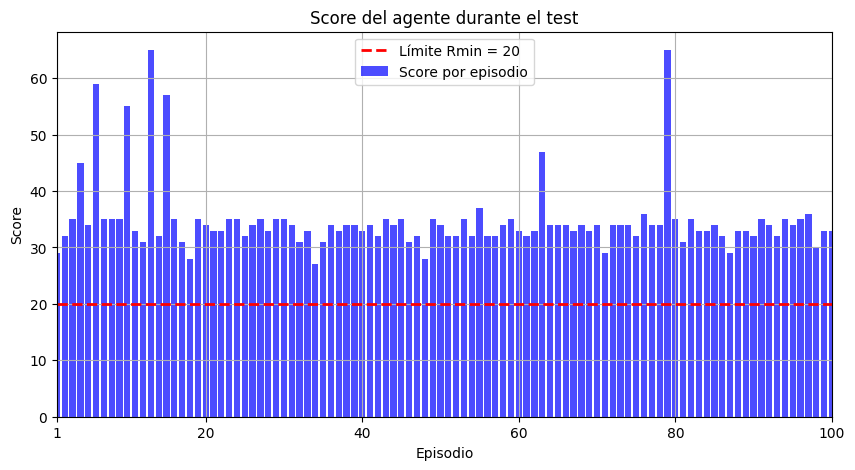

In [16]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

#### 2.3.5 Justificación de los parámetros seleccionados y de los resultados obtenidos

---

JSON combinado guardado en: Solucion2/dqn2_SpaceInvaders-v0_log_FULL.json
Total episodios combinados: 21954


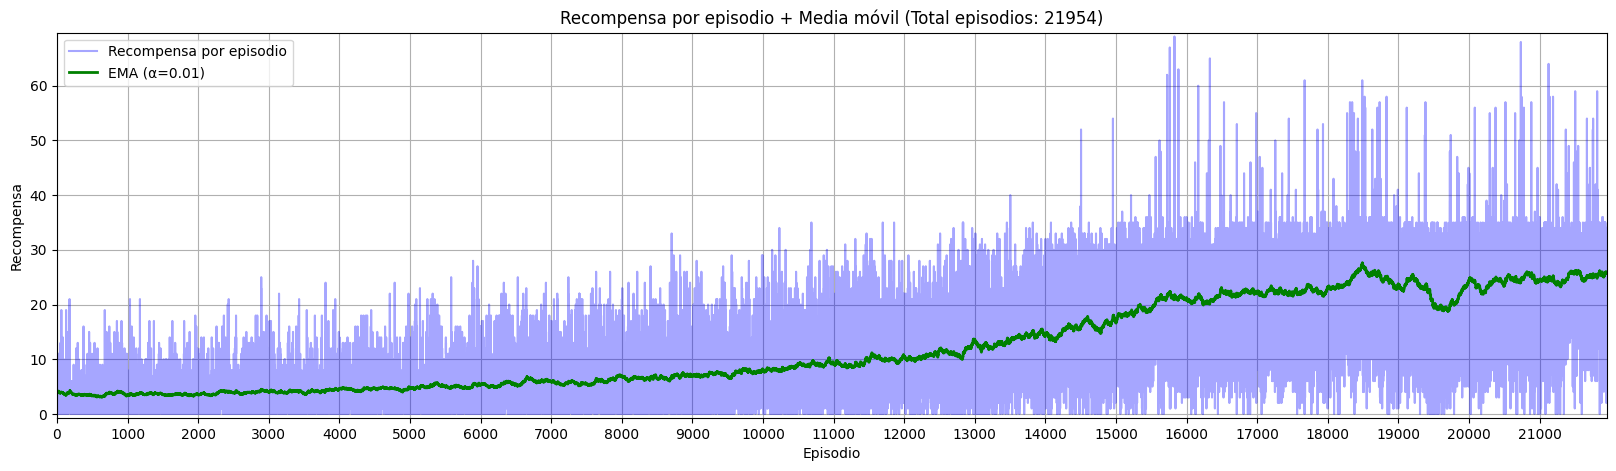

In [17]:
# Graficamos evolución de las 3 fases del entrenamiento
json_paths = [
    "Solucion2/dqn2_SpaceInvaders-v0_log_1.json",
    "Solucion2/dqn2_SpaceInvaders-v0_log_2.json",
    "Solucion2/dqn2_SpaceInvaders-v0_log_3.json",
]

merge_json_logs(json_paths, "Solucion2/dqn2_SpaceInvaders-v0_log_FULL.json")

plot_rewards("Solucion2/dqn2_SpaceInvaders-v0_log_FULL.json", 0.01)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 300 episodios...
  Episodio 300/300
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 300
Resultados Test (reward): Media: 34.71 | Máximo: 70.00 | Mínimo: 23.00
Objetivo superado: Durante 300 episodios consecutivos se ha superado o igualado los 20 puntos.




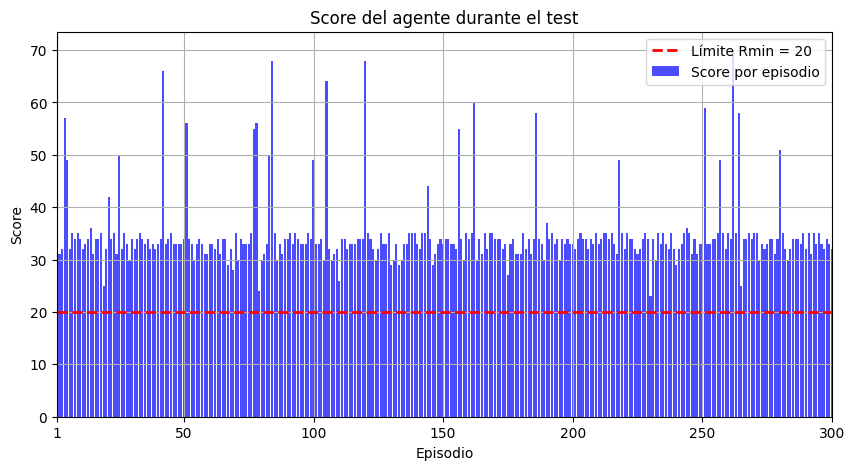

In [19]:
# Test de performance del agente durante 300 episodios
n_test = 300
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

Se ha realizado un entrenamiento por etapas:
- Etapa1: Inicialmente se optó por entrenar el modelo con 1.5M de steps. A la vista de los resultados mostrados en la curva de entrenamiento, se identificó que el modelo mantenia una pendiente ascendente en el reward medio por lo que todavia tenia margen de mejora. Se ha utilizado un learning rate de 0.00025 y una estrategia E-greedy con decaimiento progresivo desde 1 a 0.05. La red target se actualiza cada 10k steps.
- Etapa2: Se optó por una fase de ajuste fino de 750k steps adicionales para maximizar la política de explotación. Se ha utilizado un learning rate de 0.000015 y una estrategia E-greedy con decaimiento progresivo desde 0.05 a 0.01 para el 75% de los steps dejando el 25% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps para dar más estabilidad al aprendizaje y ayudar a que el error de los valores Q no oscile tanto.
- Etapa3: En vista a los resultados de la etapa anterior, se decide hacer una ultima etapa adicional de 500k steps. Se ha utilizado un learning rate de 0.00001 y una estrategia E-greedy con decaimiento progresivo desde 0.1 a 0.005 para el 80% de los steps dejando el 20% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps igual que en la etapa anterior.

Resultados:
- Tras 1.5M steps de entrenamiento, el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y una media de 31.7 puntos, comparado al proceso de entrenamiento de la primera solución se puede apreciar como gracias a seleccionar la siguiente accion con la red online pero evaluarla con la red target el entrenamiento es más consistente y rápido, obteniendo mejores resultados que con una simple DQN. El aprendizaje del agente ha ido mejorando progresivamente a lo largo de los 1.5M steps.
- Tras hacer un fine tunning de 750K steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 32,37 puntos. El agente no ha mejorado mucho durante esta etapa.
- Finalmente tras 500k steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 34.8 puntos. El agente ha mejorado claramente en esta 3ª etapa final aumentando bastante la media de las puntuaciones.
- Ejecutamos un test adicional de 300 episodios para ver comportamiento mas amplio. El resultado es de 300/300 episodios por encima de 20 puntos y la media ha sido de 34.71 puntos.
- Analizando la curva completa de entrenamiento de 2.75M de steps, vemos que el agente ha tenido un progreso claro a través de las 3 etapas desarrolladas. También cabe destacar que, comparando las gráficas del entrenamiento completo entre la primera y la segunda solución se ve claramente como con la segunda aproximación el entrenamiento da sus frutos mucho antes que con la primera solución.


## 2.4 Solución nº3 - Dueling Double DQN
En esta solucion implementamos una arquitectura basada en Dueling Doble DQN.

<p align="center">
  <img src="img/Schematic-Dueling-Q-Network.png" width="600">
</p>

La arquitectura Dueling Double DQN combina dos mejoras fundamentales sobre el DQN clásico con el objetivo de aumentar la estabilidad del aprendizaje y mejorar la estimación de los valores Q. Por un lado, el enfoque Dueling separa la red en dos ramas: una que estima el valor del estado (Value) y otra que estima la ventaja de cada acción (Advantage). Esta descomposición permite que la red aprenda a valorar estados incluso cuando las acciones disponibles no producen diferencias significativas en la recompensa inmediata, lo que acelera el aprendizaje en entornos con alta redundancia de acciones o recompensas escasas.

Por otro lado, la técnica Double DQN reduce la sobreestimación de los valores Q, un problema habitual en el DQN original. Para ello, utiliza la red principal para seleccionar la acción y la red target para evaluarla, desacoplando ambos procesos y obteniendo estimaciones más estables y realistas. La combinación de ambas ideas da lugar a un agente más robusto, menos propenso a sobreajustar y capaz de aprender políticas más precisas en entornos complejos como los juegos Atari.

#### 2.4.1 Configuración base

In [23]:
# Parametros fijos
seed = 42
Memory_Size = 1000000
N_Solucion = 3
Reward_min = 20
Episodios_min = 100
Training_Steps = 900000

# Definimos la semilla para la reproducibilidad de la ejecución
set_seeds(seed)

# Cargamos entornos de simulacion
env_tr = make_env(seed, training=True)
env_te = make_env(seed, training=False)

# Extraemos informacion sobre las acciones y el espacio de observacion del entorno
nb_actions = env_tr.action_space.n
height, width, channels = env_tr.observation_space.shape

print(f"Numero de acciones del juego: {nb_actions}")
print(
    f"Tipo de acciones disponibles en el juego: {env_tr.unwrapped.get_action_meanings()}"
)
print(f"Dimensiones del Frame del juego: [{height},{width},{channels}]")

Numero de acciones del juego: 6
Tipo de acciones disponibles en el juego: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del Frame del juego: [210,160,3]


#### 2.4.2 Implementación de la red neuronal

In [24]:
# Definimos la arquitectura de red en una funcion, asi podemos llamarla directamente y pasarle los parametros que vamos a evaluar.
# DQN
def BuildDcnn(n_classes=6):
    model = Sequential()
    # Entrada
    model.add(Permute((2, 3, 1), input_shape=(ef.WINDOW_LENGTH,) + ef.INPUT_SHAPE))

    # Base Model - Bloque convolucional
    model.add(Conv2D(32, (8, 8), strides=(4, 4), activation="relu"))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), activation="relu"))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu"))

    # Top Model - Capa FC.
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))

    # Capa final: Q(s,a)
    model.add(Dense(n_classes, activation="linear"))

    return model


# mostramos datos entrada
print("Tamaño de la imagen de entrada:", ef.IM_SHAPE)
print("Numero de clases/acciones:", nb_actions)

# Llamamos a la funcion de construccion de la red del modelo. Esta red neuronal: recibe el estado s, produce vector con los valores Q(s,a), en este caso
# tendremos un vector con 6 componentes (6 acciones). La red evalua cual es la mejor Q(s,a).
model = BuildDcnn(nb_actions)

# Mostramos la arquitectura de la red declarada
model.summary()

Tamaño de la imagen de entrada: (84, 84, 4)
Numero de clases/acciones: 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_2 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________

#### 2.4.3 Implementación de la solución DQN

In [25]:
# Definimos nuestro agente: Buffer memoria, policy y tipo agente.
def BuildAgent(model, memory_size, tr_steps, n_actions, lr=0.0005):

    # Preparación de la memoria (usamos memory replay en DQN).
    ReplayBuffer = SequentialMemory(limit=memory_size, window_length=ef.WINDOW_LENGTH)

    # Llamamos a clase para pre-procesado de las observaciones.
    processor = AtariProcessor()

    # Definimos la policy, estrategia para seleccionar las acciones. Decide que accion tomar.
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),  # Estrategia E-greedy.
        attr="eps",
        value_max=1.0,  # Explora totalmente al inicio
        value_min=0.1,  # Explora poco al final del entrenamiento
        value_test=0.001,  # Exploración mínima en test
        nb_steps=tr_steps,  # Duración del decaimiento
    )

    # Definición del agente DQN. Aqui se junta todo, es el cerebro que coordina todo.
    # Llama a la ANN para estimar la Q, aplica la policy para elegir la acción, interactua con el entorno y usa el replay bufer para guardar las experiencias,
    # entrena la red mediante el target network para estabilizar el aprendizaje y la actualiza con la función de perdidas.
    dqn = DQNAgent(
        model=model,  # La red CNN que estima la distribución Q
        nb_actions=n_actions,  # Número de acciones posibles en el entorno
        memory=ReplayBuffer,  # Replay buffer para almacenar transiciones
        policy=policy,  # Política/Estrategia
        processor=processor,  # Preprocesado de observaciones
        nb_steps_warmup=100000,  # Pasos iniciales solo explorando (sin entrenar)
        target_model_update=5e-3,  # Frecuencia de actualización del target network (=5e-3 activamos soft update)
        train_interval=4,  # Entrenar cada X pasos de interacción
        gamma=0.99,  # Factor de descuento para recompensas futuras
        batch_size=32,  # Tamaño de batch
        enable_double_dqn=True,  # Activar double dqn
        enable_dueling_network=True,  # Activar dueling netowrk
        dueling_type="avg",  # Tipo de dueling
        delta_clip=1.0,  # Delta clip
    )

    # Compilación del agente
    dqn.compile(Adam(learning_rate=lr, clipnorm=10.0), metrics=["mae"])

    # Mostrar confirmacion
    print("Agente creado con exito.")

    return dqn


# Construimos el agente.
agent = BuildAgent(model, Memory_Size, Training_Steps, nb_actions, 1e-4)

Agente creado con exito.


#### 2.4.4 Entrenamiento del Agente DQN
Configuramos y ejecutamos el entrenamiento del agente. Se realiza un entrenamiento en 3 etapas, con diferente numero de steps e hiperparametros del agente en cada una de ellas. Al final de este a apartado se analizan los resultados.

##### 2.4.4.1 Etapa 1: Entrenamiento desde 0 con 0.9M steps

Cargando pesos: Solucion3/dqn3_SpaceInvaders-v0_weights_final_1.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 497s 5ms/step - reward: 3.8449
1599 episodes - episode_reward: 3.845 [0.000, 29.000] - loss: 0.000 - mae: 0.000 - mean_q: 0.000 - mean_eps: 0.000
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2976s 30ms/step - reward: 3.8783
1586 episodes - episode_reward: 3.878 [0.000, 24.000] - loss: 0.094 - mae: 2.950 - mean_q: 3.535 - mean_eps: 0.866
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 3284s 33ms/step - reward: 4.4394
1509 episodes - episode_reward: 4.439 [0.000, 24.000] - loss: 0.197 - mae: 6.759 - mean_q: 8.116 - mean_eps: 0.776
---

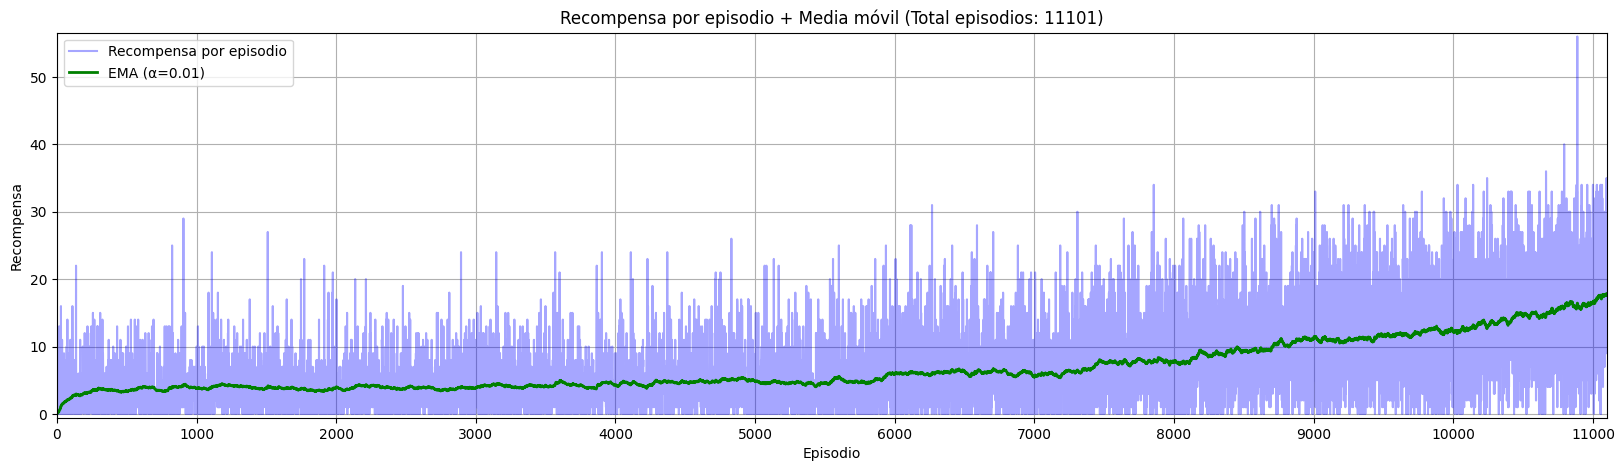

In [26]:
# Entrenamos agente.
n_tr = 1
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_1.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 22.54 | Máximo: 36.00 | Mínimo: 10.00
Objetivo no alcanzado: Se han obtenido 71 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




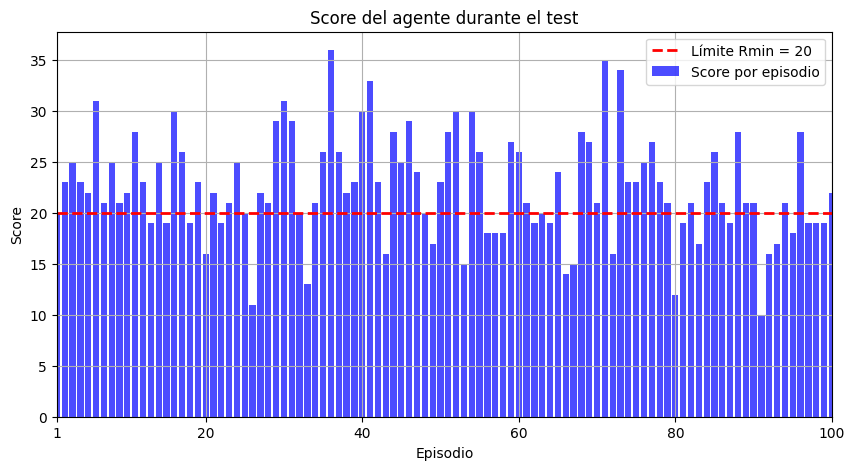

In [27]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.4.4.2 Etapa 2: Fine Tuning de 600k steps

Cargando pesos: Solucion3/dqn3_SpaceInvaders-v0_weights_final_2.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 2238s 22ms/step - reward: 15.5520
712 episodes - episode_reward: 15.552 [0.000, 57.000] - loss: 0.123 - mae: 9.979 - mean_q: 12.077 - mean_eps: 0.178
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2777s 28ms/step - reward: 17.0318
724 episodes - episode_reward: 17.032 [0.000, 44.000] - loss: 0.125 - mae: 10.264 - mean_q: 12.426 - mean_eps: 0.146
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 3083s 31ms/step - reward: 18.4023
696 episodes - episode_reward: 18.402 [0.000, 41.000] - loss: 0.121 - mae: 10.245 - mean_q: 12.399 - mean_eps:

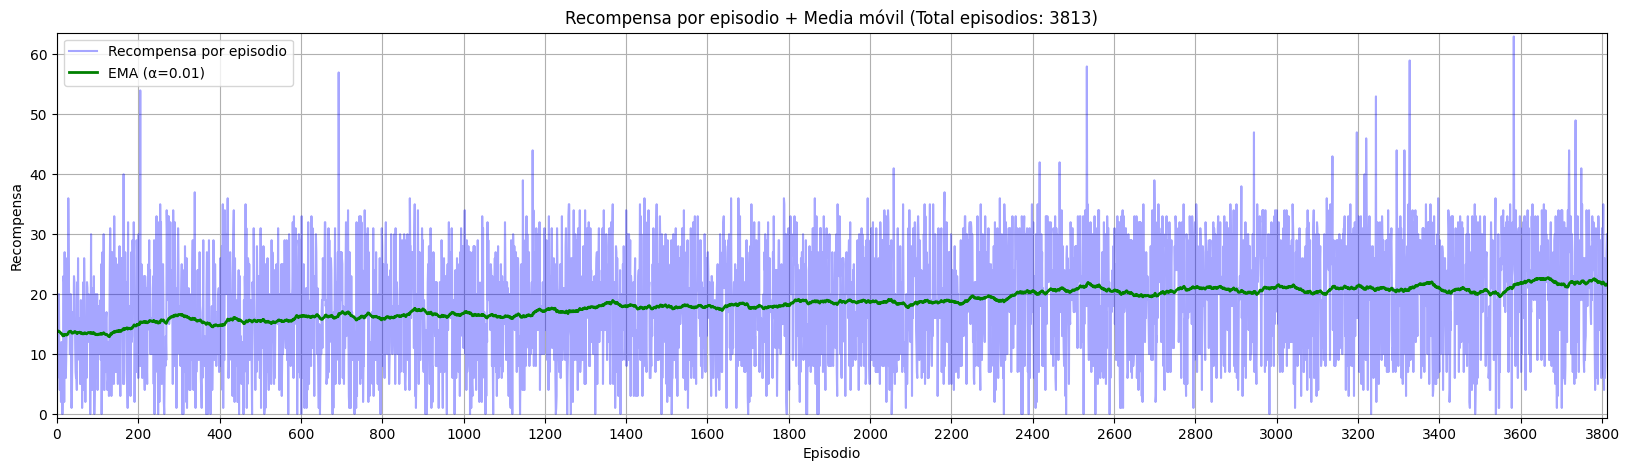

In [28]:
# Fijamos steps.
n_tr = 2
Training_Steps = 600000
decay_steps = 500000

# Reducimos learning rate para fine‑tuning
LearningRate = 1e-4
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.10,  # Continua donde lo habia dejado
    value_min=0.02,  # termina casi determinista (2% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Reducimos el numero de steps de exploracion inicial.
agent.nb_steps_warmup = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_2.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 32.21 | Máximo: 66.00 | Mínimo: 11.00
Objetivo no alcanzado: Se han obtenido 98 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




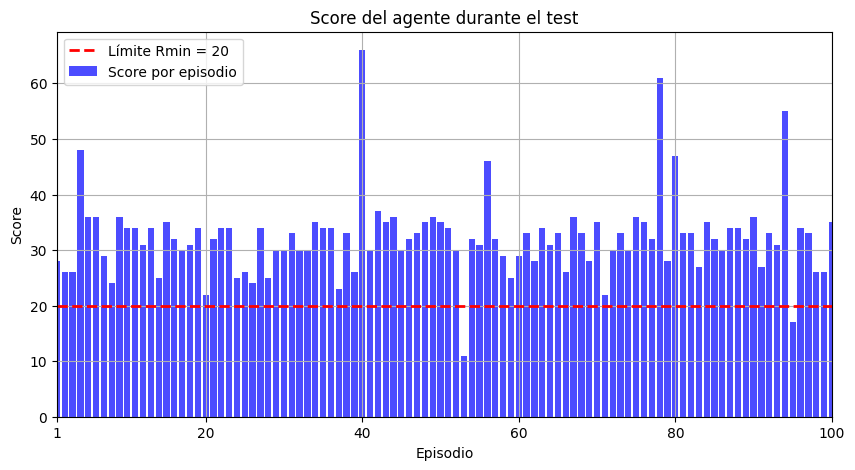

In [30]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.4.4.3 Etapa 3: Fine Tuning de 300k steps

Cargando pesos: Solucion3/dqn3_SpaceInvaders-v0_weights_final_3.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 2080s 21ms/step - reward: 26.1796
540 episodes - episode_reward: 26.180 [0.000, 71.000] - loss: 0.069 - mae: 8.665 - mean_q: 10.510 - mean_eps: 0.017
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2540s 25ms/step - reward: 26.7761
527 episodes - episode_reward: 26.776 [3.000, 60.000] - loss: 0.062 - mae: 8.299 - mean_q: 10.091 - mean_eps: 0.012
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 2777s 28ms/step - reward: 26.8692
543 episodes - episode_reward: 26.869 [1.000, 65.000] - loss: 0.062 - mae: 8.302 - mean_q: 10.101 - mean_eps: 0

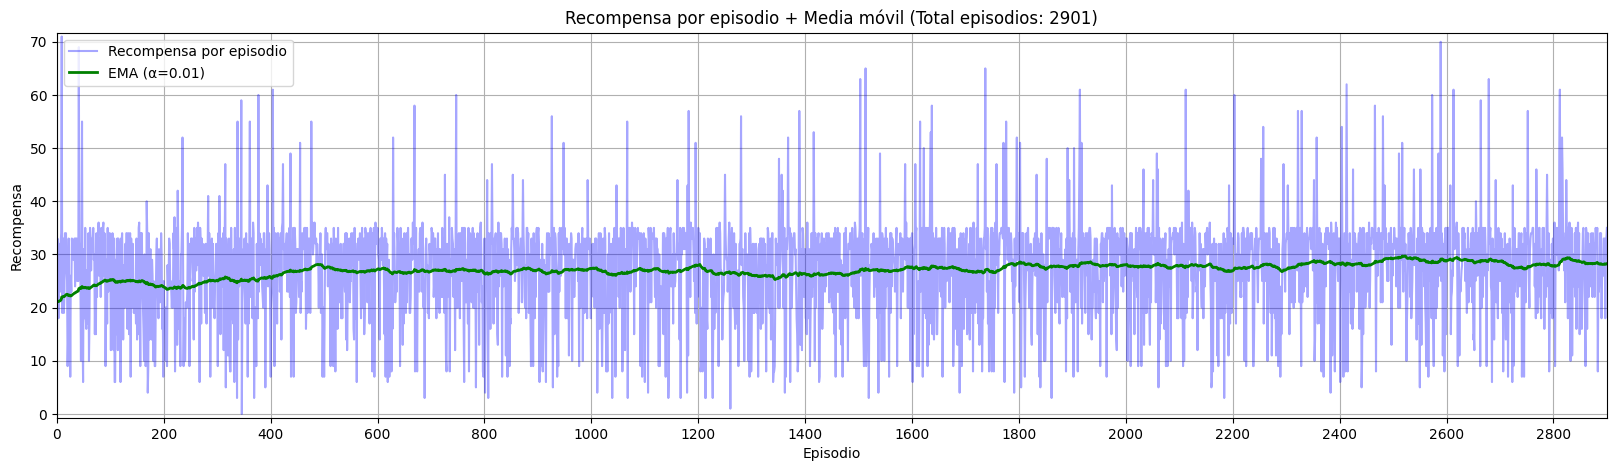

In [31]:
# Fijamos steps.
n_tr = 3
Training_Steps = 300000

# Reducimos learning rate para fine‑tuning
LearningRate = 5e-5
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.02,  # Continua donde lo habia dejado
    value_min=0.01,  # termina casi determinista (2% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=Training_Steps,
)

# Reducimos el numero de steps de exploracion inicial.
agent.nb_steps_warmup = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 38.78 | Máximo: 71.00 | Mínimo: 26.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




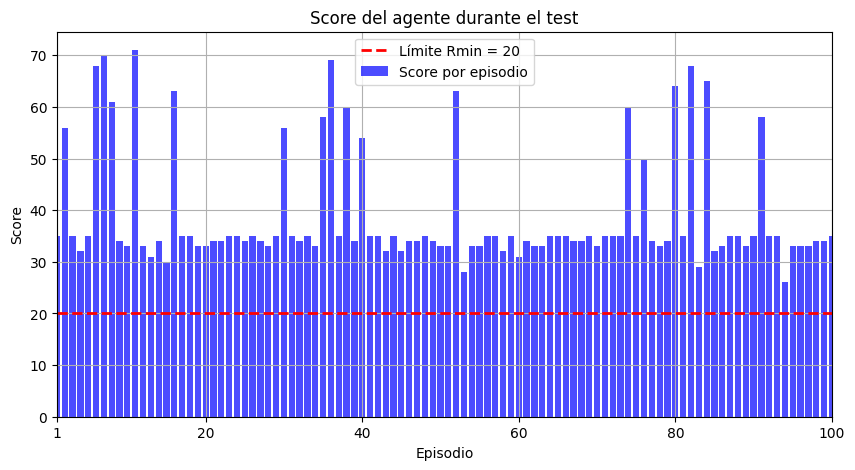

In [32]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

#### 2.4.5 Justificación de los parámetros seleccionados y de los resultados obtenidos

JSON combinado guardado en: Solucion3/dqn3_SpaceInvaders-v0_log_FULL.json
Total episodios combinados: 17815


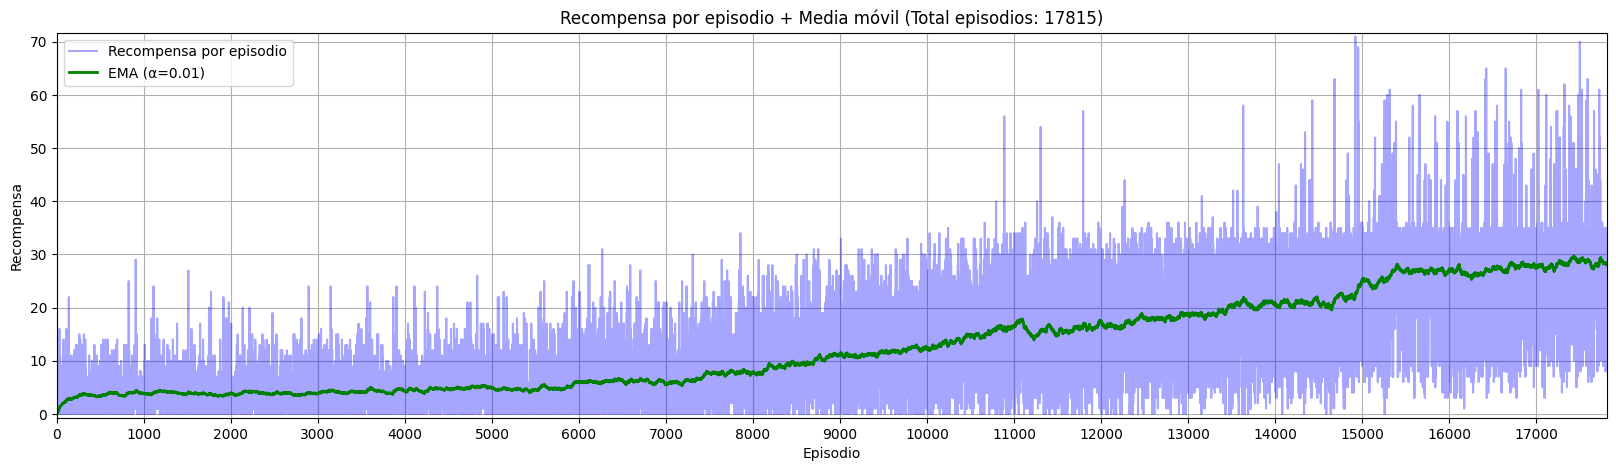

In [33]:
# Graficamos evolución de las 3 fases del entrenamiento
json_paths = [
    "Solucion3/dqn3_SpaceInvaders-v0_log_1.json",
    "Solucion3/dqn3_SpaceInvaders-v0_log_2.json",
    "Solucion3/dqn3_SpaceInvaders-v0_log_3.json",
]

merge_json_logs(json_paths, "Solucion3/dqn3_SpaceInvaders-v0_log_FULL.json")

plot_rewards("Solucion3/dqn3_SpaceInvaders-v0_log_FULL.json", 0.01)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 300 episodios...
  Episodio 300/300
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 300
Resultados Test (reward): Media: 39.13 | Máximo: 93.00 | Mínimo: 25.00
Objetivo superado: Durante 300 episodios consecutivos se ha superado o igualado los 20 puntos.




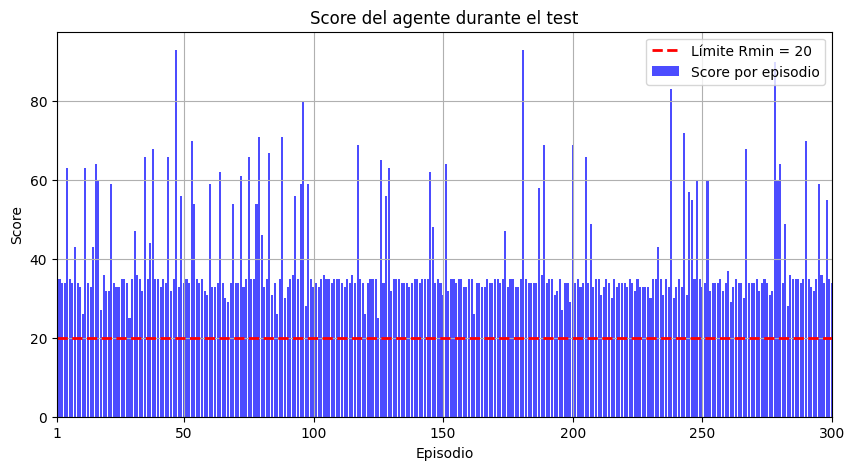

In [34]:
# Test de performance del agente durante 300 episodios
n_test = 300
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

---

Se ha realizado un entrenamiento por etapas:
- Etapa1: Inicialmente se optó por entrenar el modelo con 0.9M de steps. A la vista de los resultados mostrados en la curva de entrenamiento, se identificó que el modelo mantenia una pendiente ascendente en el reward medio por lo que todavia tenia margen de mejora. Se ha utilizado un learning rate de 1e-4 y una estrategia E-greedy con decaimiento progresivo desde 1 a 0.1.
- Etapa2: Se optó por una fase de ajuste fino de 600k steps adicionales para maximizar la política de explotación. Se ha utilizado un learning rate de 1e-4 y una estrategia E-greedy con decaimiento progresivo desde 0.1 a 0.02 para 500k steps dejando los ultimos 100k steps con epsilon fijo para hacer entrenamiento mas determinista.
- Etapa3: En vista a los resultados de la etapa anterior, se decide hacer una ultima etapa adicional de 300k steps. Se ha utilizado un learning rate de 5e-5 y una estrategia E-greedy con decaimiento progresivo desde 0.02 a 0.01 para hacer el entrenamiento mas determinista.

Resultados:
- Tras 0.9M steps de entrenamiento, el test del agente ha dado un resultado de 71/100 episodios por encima de 20 puntos y una media de 22.5 puntos, lo cual no está nada mal. El aprendizaje del agente ha ido mejorando progresivamente a lo largo de los 0.9M steps.
- Tras hacer un fine tunning de 600K steps adicionales el test del agente ha dado un resultado de 98/100 episodios por encima de 20 puntos y la media ha sido de 32.2 puntos. El agente ha mejorado claramente en esta 2ª etapa.
- Finalmente tras 300k steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 38.7 puntos. El agente ha mejorado claramente en esta 3ª etapa final hasta superar el reto.
- Ejecutamos un test adicional de 300 episodios para ver comportamiento mas amplio. El resultado es de 300/300 episodios por encima de 20 puntos y la media ha sido de 39.1 puntos.
- El performance de este agente es superior al obtenido en el experimento 1 (agente DQN) pero con 1M de steps menos de entrenamiento, lo que confirma la eficiencia de esta solución. 
- Analizando la curva completa de entrenamiento de 1.8M de steps, vemos que el agente ha tenido un progreso claro a través de las 3 etapas desarrolladas y aún no se observa estancamiento. Se podria seguir entrenando más.


---
# 3. Anexos

## 3.1 Justificación de los parámetros seleccionados y de los resultados obtenidos

In [35]:
# Como cargar directamente fichero .md y mostrarlo en el notebook.
with open("Anexo_MEMORIA.md", "r", encoding="utf-8") as f:
    contenido = f.read()

display(Markdown(contenido))

### Justificación de los parámetros seleccionados y de los resultados obtenidos

El diseño experimental se ha basado en el conjunto de hiperparámetros estándar introducido por DeepMind para el entrenamiento de agentes DQN en Atari 2600 (Mnih et al., 2015), ampliamente replicado en la literatura posterior y considerado el *baseline* de referencia para el entorno **Space Invaders**.

Este conjunto de parámetros define tanto el preprocesado de las observaciones como la arquitectura de la red y la dinámica básica del aprendizaje, proporcionando un punto de partida contrastado y reproducible.

---

#### Learning rate y estabilidad del aprendizaje

El valor del *learning rate* se ha fijado inicialmente en **learning_rate = 1e-4**, inferior al valor clásico utilizado en el DQN original (2.5e-4). Esta elección responde a un compromiso explícito entre velocidad de aprendizaje y estabilidad.

Dado que el criterio de evaluación prioriza la **robustez del comportamiento** frente a la optimización de la recompensa media —concretamente, que el mínimo de las recompensas en los últimos 100 episodios supere un umbral—, se ha optado por un *learning rate* más conservador, que reduce la probabilidad de actualizaciones bruscas de los valores Q y minimiza la aparición de episodios catastróficos.

En la fase final del entrenamiento, el *learning rate* se reduce adicionalmente a **5e-5**, favoreciendo una convergencia más estable de la política aprendida.

---

#### Actualización de la red objetivo (Polyak averaging)

A diferencia del DQN original, que emplea actualizaciones “duras” de la red objetivo cada cierto número de pasos, se ha utilizado una **actualización suave de la red objetivo** mediante *Polyak averaging*.

Este mecanismo actualiza la red objetivo de forma progresiva como una media móvil exponencial de la red principal, reduciendo la variación temporal del objetivo de entrenamiento y mejorando la estabilidad del aprendizaje. Esta elección resulta especialmente adecuada en un contexto donde se busca minimizar la probabilidad de episodios con bajo rendimiento, incluso a costa de una ligera reducción en la velocidad de aprendizaje inicial.

---

#### Entrenamiento por etapas y control de la exploración

Con el objetivo de equilibrar exploración, aprendizaje y estabilidad, el entrenamiento se ha estructurado en **tres etapas**, redefiniendo el *schedule* de la política ε-greedy en cada una de ellas.

Este enfoque permite adaptar dinámicamente el nivel de exploración a la fase de aprendizaje del agente.

---

##### Etapa 1: Aprendizaje inicial (hasta ~0.9M pasos)

```python
value_max = 1.0
value_min = 0.10
nb_steps  = 1_000_000
value_test = 0.0
```

En esta etapa, el agente explora de forma intensiva el espacio de estados y acciones, permitiendo la construcción de una representación inicial adecuada del entorno. El descenso progresivo de ε desde 1.0 hasta 0.10 asegura una transición gradual desde la exploración aleatoria hacia el aprovechamiento de la política aprendida.

---

##### Etapa 2: Mejora de la consistencia (≈600k pasos)

```python
value_max = 0.10
value_min = 0.02
nb_steps  = 500_000
value_test = 0.0
```

Una vez adquirida una política razonable, se reduce el rango de exploración para reforzar comportamientos consistentes y mejorar la estabilidad del rendimiento. Esta etapa permite incrementar la frecuencia de episodios con recompensas superiores al umbral objetivo, aunque todavía pueden aparecer episodios con bajo rendimiento debido a la exploración residual.

---

##### Etapa 3: Estabilización del rendimiento mínimo (≈300k pasos)

```python
value_max = 0.02
value_min = 0.01
nb_steps  = 300_000
value_test = 0.0
```

En la etapa final, la exploración se mantiene en niveles mínimos, limitándose a una pequeña probabilidad de acciones aleatorias con el fin de evitar sobreajuste extremo. El objetivo principal de esta fase es **reducir la variabilidad del rendimiento** y minimizar la aparición de episodios con baja recompensa, maximizando así el valor mínimo observado en la ventana de evaluación.

La reducción adicional del *learning rate* en esta etapa refuerza este objetivo, favoreciendo una convergencia suave y estable de la política final.

---

#### Relación con los resultados obtenidos

La combinación de un *learning rate* conservador, la actualización suave de la red objetivo y un esquema de entrenamiento por etapas ha permitido alcanzar el criterio de evaluación planteado, logrando que el mínimo de las recompensas en los últimos 100 episodios supere el umbral establecido, al tiempo que se mantiene una recompensa media elevada.

Este resultado confirma la adecuación de las decisiones de diseño adoptadas, especialmente en un contexto donde la robustez del comportamiento es prioritaria frente a la optimización exclusiva de la recompensa media.

---

#### Estabilización del entrenamiento: normalización del gradiente y función de pérdida

Con el objetivo de mejorar la estabilidad del entrenamiento y evitar problemas numéricos asociados a actualizaciones excesivas de los parámetros, se han incorporado dos mecanismos adicionales de regularización ampliamente utilizados en aprendizaje por refuerzo profundo: **clipping del gradiente** y **pérdida de Huber**.

---

##### Clipping del gradiente (`clipnorm = 10`)

Durante el entrenamiento de redes neuronales profundas en aprendizaje por refuerzo, es habitual que la señal de error presente una varianza elevada, especialmente en las primeras fases del aprendizaje o tras actualizaciones de la red objetivo. Esto puede dar lugar a **gradientes excesivamente grandes**, provocando inestabilidad o divergencia del proceso de optimización.

Para mitigar este efecto, se ha aplicado *gradient clipping* mediante la normalización del gradiente, fijando un valor máximo de norma:

```python
clipnorm = 10
```

Este mecanismo limita la magnitud total del vector gradiente sin alterar su dirección, evitando actualizaciones abruptas de los pesos y favoreciendo un aprendizaje más estable. La elección de este valor sigue prácticas habituales en aprendizaje profundo y resulta especialmente adecuada en combinación con redes convolucionales y entrenamiento fuera de política (*off-policy*), como es el caso del DQN.

---

##### Función de pérdida Huber (`delta = 1.0`)

En lugar de emplear el error cuadrático medio (MSE), se ha utilizado la **pérdida de Huber** con un parámetro:

```python
delta = 1.0
```

La pérdida de Huber combina las ventajas del MSE y del error absoluto medio (MAE):

* se comporta como una pérdida cuadrática para errores pequeños,
* y como una pérdida lineal para errores grandes.

Esta propiedad la hace especialmente robusta frente a valores atípicos (*outliers*) en la señal de error temporal-diferencial (TD error), que son frecuentes en aprendizaje por refuerzo debido a recompensas inesperadas o transiciones poco comunes.

El valor (\delta = 1.0) coincide con el utilizado en el DQN original de DeepMind y constituye un estándar en la literatura para entornos Atari.

---

##### Contribución a la robustez del comportamiento

La combinación de *gradient clipping* y pérdida de Huber permite:

* limitar la influencia de transiciones atípicas sobre el proceso de aprendizaje,
* reducir la probabilidad de inestabilidades numéricas,
* y favorecer una convergencia más suave de la política aprendida.

Estas medidas resultan especialmente relevantes en un contexto donde el criterio de evaluación prioriza la **robustez del comportamiento** y la reducción de episodios con bajo rendimiento, contribuyendo de forma indirecta a mejorar el valor mínimo observado en la fase de evaluación.

---

##### Relación con el conjunto de decisiones metodológicas

El uso de *gradient clipping* y pérdida de Huber complementa otras decisiones orientadas a la estabilidad del entrenamiento, como el uso de Polyak averaging, Double DQN y la arquitectura Dueling, conformando un conjunto coherente de técnicas destinadas a reducir la variabilidad del aprendizaje y a obtener una política final robusta y consistente.

---

### Justificación del uso de wrappers del entorno Atari

Con el fin de reproducir el entorno experimental empleado en los trabajos originales de DeepMind y sus posteriores replicaciones, se han aplicado una serie de wrappers estándar sobre el entorno `SpaceInvaders-v0`. Estos wrappers permiten controlar el preprocesado de observaciones, la dinámica temporal y la definición de episodios, mejorando la estabilidad y eficiencia del aprendizaje sin modificar la lógica del juego subyacente.

#### NoopResetEnv

El wrapper `NoopResetEnv` introduce una secuencia aleatoria de acciones nulas (`NOOP`) al inicio de cada episodio, con un número máximo predefinido.

Este procedimiento, introducido por DeepMind, tiene como objetivo:

* aumentar la diversidad de estados iniciales,
* evitar que el agente aprenda políticas excesivamente dependientes de un estado inicial fijo,
* y mejorar la generalización y robustez del comportamiento aprendido.

El uso de `NoopResetEnv` permite que el agente se enfrente a diferentes configuraciones iniciales del entorno, simulando variaciones naturales en el inicio de la partida.

---

#### FireResetEnv

En Space Invaders, el juego no comienza hasta que se ejecuta la acción `FIRE`. El wrapper `FireResetEnv` asegura que, tras cada `reset`, se ejecute automáticamente la acción necesaria para iniciar la partida.

Este wrapper:

* garantiza la correcta inicialización del entorno,
* evita episodios triviales en los que el agente no recibe observaciones significativas,
* y permite que el agente aprenda directamente sobre estados relevantes del juego.

---

#### MaxAndSkipEnv

El wrapper `MaxAndSkipEnv` aplica dos transformaciones clave:

1. **Frame skipping**, ejecutando la misma acción durante varios pasos consecutivos.
2. **Max-pooling** sobre los dos últimos frames observados.

Este mecanismo:

* reduce la frecuencia efectiva de decisión del agente,
* disminuye el coste computacional del entrenamiento,
* y atenúa el efecto del parpadeo (flickering) característico de los juegos Atari.

El uso de `skip=4` sigue exactamente la configuración empleada por DeepMind y es considerado un estándar en aprendizaje profundo sobre Atari.

---

#### EpisodicLifeEnv (solo durante entrenamiento)

El wrapper `EpisodicLifeEnv` redefine el final de un episodio cada vez que el agente pierde una vida, sin reiniciar completamente el entorno.

Este enfoque:

* proporciona una señal de aprendizaje más densa,
* acelera el proceso de aprendizaje,
* y facilita la asociación entre errores locales y sus consecuencias inmediatas.

Durante la fase de entrenamiento, esta redefinición de episodios contribuye a una convergencia más rápida y estable. Sin embargo, para garantizar una evaluación fiel al objetivo del problema, este wrapper se desactiva durante la fase de test, evaluando al agente sobre partidas completas.

---

#### Relación con el objetivo de robustez

La combinación de estos wrappers permite:

* entrenar al agente bajo condiciones variadas y realistas,
* reducir la varianza del entrenamiento,
* y mejorar la estabilidad de la política aprendida.

En conjunto, estas decisiones metodológicas contribuyen directamente a alcanzar el criterio de evaluación planteado, basado en la robustez del comportamiento (`min(last100) > 20`), más allá de la mera optimización de la recompensa media.

Perfecto, ese es **el último bloque clave** y además encaja muy bien con tu objetivo de **robustez**.
Te dejo una **redacción académica**, alineada con la literatura y conectada explícitamente con `min(last100) > 20`.

---

### Uso de Double DQN y arquitectura Dueling

Además del DQN estándar, se han incorporado dos mejoras ampliamente aceptadas en la literatura: **Double DQN** y la **arquitectura Dueling**. Ambas extensiones están orientadas a mejorar la estabilidad del aprendizaje y la calidad de la estimación de los valores Q, sin modificar la estructura general del algoritmo.

---

#### Double DQN

El algoritmo DQN original tiende a **sobreestimar los valores Q**, debido a que la selección y la evaluación de la acción se realizan utilizando la misma red neuronal. Esta sobreestimación puede derivar en políticas inestables y comportamientos subóptimos, especialmente en entornos estocásticos como los juegos Atari.

Double DQN mitiga este problema desacoplando ambos procesos:

* la **red principal** se utiliza para seleccionar la acción,
* mientras que la **red objetivo** se emplea para evaluar su valor.

Este mecanismo reduce el sesgo optimista en la estimación de los valores Q, produciendo estimaciones más realistas y estables. En el contexto del presente trabajo, la reducción de sobreestimación contribuye a evitar decisiones excesivamente arriesgadas que pueden desembocar en episodios con bajo rendimiento, favoreciendo así un comportamiento más robusto.

---

#### Arquitectura Dueling

La arquitectura Dueling separa explícitamente la estimación del **valor del estado** (V(s)) y de la **ventaja de cada acción** (A(s,a)), combinándolos posteriormente para obtener el valor Q:

[
Q(s,a) = V(s) + \left(A(s,a) - \frac{1}{|\mathcal{A}|}\sum_{a'} A(s,a')\right)
]

Esta descomposición resulta especialmente beneficiosa en entornos donde, para muchos estados, la elección concreta de la acción tiene un impacto limitado sobre la recompensa inmediata.

En Space Invaders, numerosos estados comparten un valor intrínseco similar independientemente de la acción ejecutada (por ejemplo, desplazamientos laterales sin disparo). La arquitectura Dueling permite aprender de forma más eficiente el valor de estos estados, mejorando la generalización y la estabilidad del comportamiento aprendido.

---

#### Contribución conjunta a la robustez

La combinación de Double DQN y arquitectura Dueling permite:

* reducir el sesgo en la estimación de los valores Q,
* mejorar la eficiencia del aprendizaje de estados relevantes,
* y disminuir la variabilidad del rendimiento entre episodios.

Estas propiedades son especialmente relevantes cuando el criterio de evaluación se basa en el **rendimiento mínimo** observado en una ventana de episodios, ya que ayudan a reducir la probabilidad de decisiones erráticas o excesivamente optimistas que puedan dar lugar a episodios con baja recompensa.

---

#### Justificación de la elección metodológica

Tanto Double DQN como la arquitectura Dueling forman parte del conjunto de extensiones estándar del DQN moderno y se han utilizado con éxito en múltiples trabajos posteriores al DQN original, incluyendo variantes como Rainbow DQN.

Su incorporación en este trabajo responde a la necesidad de mejorar la estabilidad y robustez del aprendizaje, manteniendo al mismo tiempo la compatibilidad con el entorno experimental y las restricciones impuestas (keras-rl2, gym clásico y SpaceInvaders-v0).

---

#### Relación con los resultados obtenidos

La adopción de estas técnicas, junto con el control progresivo de la exploración y el uso de Polyak averaging, ha contribuido de forma significativa a alcanzar el criterio de evaluación establecido, logrando un comportamiento consistente que evita episodios de bajo rendimiento en la fase de evaluación.

---



## 3.2 Funciones libreria proyecto "env_functions.py"

In [36]:
# Como cargar directamente fichero .py y mostrarlo en el notebook.
with open("env_functions.py", "r", encoding="utf-8") as f:
    contenido = f.read()

display(Markdown(f"```python\n{contenido}\n```"))

```python
#==================================================================================================
#              08MIAR 2025 Grupo 21 - Fichero de Funciones Básicas Proyecto Programación RL
#==================================================================================================
#----------------------------- 1. Importación Librerias y funciones -------------------------------
import os
import glob
import json
import sys
import random
import gym
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from rl.agents.dqn import DQNAgent
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from rl.core import Processor
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from collections import deque
from pathlib import Path 

#-------------------------------------- 2. Configuración Básica -----------------------------------
ENV_NAME = "SpaceInvaders-v0"
INPUT_SHAPE = (84, 84)     # (H, W)
WINDOW_LENGTH = 4          # stack in keras-rl memory/model

IM_SHAPE = (INPUT_SHAPE[0], INPUT_SHAPE[1], WINDOW_LENGTH)

#-------------------------------------- 3. Wrappers Gym Clasico -----------------------------------
# WRAPPERS (compatibles con gym clasico y keras-rl2)
# keras-rl2 espera:
#   reset() -> obs
#   step()  -> obs, reward, done, info

# MaxAndSkipEnv: aplica dos transformaciones clave:
# **Frame skipping**, ejecutando la misma acción durante varios pasos consecutivos.
# **Max-pooling** sobre los dos últimos frames observados.
class MaxAndSkipEnv(gym.Wrapper):
    """Frame-skip + max-pooling de los últimos 2 frames."""
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip
        self._obs_buffer = deque(maxlen=2)

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs  # keras-rl2 espera solo obs

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            terminated = terminated or done
            if done:
                break

        max_frame = np.maximum(self._obs_buffer[0], self._obs_buffer[-1])
        done = terminated
        return max_frame, total_reward, done, info  # keras-rl2 API

# FireResetEnv: tras cada `reset` ejecuta automáticamente la acción necesaria para iniciar la partida.
class FireResetEnv(gym.Wrapper):
    """Asegura que el juego arranque (SpaceInvaders puede requerir FIRE para empezar)."""
    def reset(self, **kwargs):
        obs = self.env.reset()

        # Acción 1 suele ser FIRE en SpaceInvaders ALE
        obs, _, done, info = self.env.step(1)

        if done:
            obs = self.env.reset()
        return obs
    
# NoopResetEnv: introduce una secuencia aleatoria de acciones nulas (`NOOP`) al inicio de cada episodio,
#               con un número máximo predefinido.
class NoopResetEnv(gym.Wrapper):
    """
    Ejecuta un número aleatorio de acciones NOOP tras reset.
    """
    def __init__(self, env, noop_max=30):
        super().__init__(env)
        self.noop_max = noop_max
        self.noop_action = 0  # NOOP en Atari

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)

        # Número aleatorio de NOOPs
        n_noops = np.random.randint(1, self.noop_max + 1)

        for _ in range(n_noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)

        return obs
    
# EpisodicLifeEnv: redefine el final de un episodio cada vez que el agente pierde una vida, 
#                  sin reiniciar completamente el entorno.
class EpisodicLifeEnv(gym.Wrapper):
    """
    Hace 'done=True' cuando se pierde una vida (pero no es game over).
    Acelera aprendizaje en Atari (solo recomendable en TRAIN).
    """
    def __init__(self, env, lives_key="ale.lives"):
        super().__init__(env)
        self.lives_key = lives_key
        self.lives = 0

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.lives = 0
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)

        lives = info.get(self.lives_key, None)
        if lives is not None:
            if self.lives == 0:
                self.lives = lives

            # Si pierdes una vida pero NO es game over, cortamos el episodio
            if (lives < self.lives) and (lives > 0):
                done = True

            self.lives = lives

        return obs, reward, done, info


#--------------------------- 4. PROCESSOR (reward clipping + preprocessing) -----------------------
class AtariProcessor(Processor):
    def process_observation(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, INPUT_SHAPE, interpolation=cv2.INTER_AREA)
        return resized.astype(np.uint8)

    def process_state_batch(self, batch):
        return batch.astype("float32") / 255.0

    def process_reward(self, reward):
        return np.clip(reward, -1.0, 1.0)


#-------------------------------- 5. Funciones de monitorización ----------------------------------
# Función para evaluación resultado del agente.
def agent_eval(hist, Nepi=20, Rmin=20):
    """
    Evalúa el rendimiento del agente de acuerdo al enunciado del problema a partir de la historia de test.
    
    Parámetros:
    - hist: objeto devuelto por dqn.test()
    - Nepi: número de episodios consecutivos a comprobar (int)
    - Rmin: recompensa mínima exigida en cada episodio (int)
    
    Imprime:
    - número total de episodios ejecutados
    - media de recompensas
    - si ha superado el reto de N episodios consecutivos con reward >= Rmin
    """  
    # Extraemos puntuaciones del historial de episodios
    score = hist.get('episode_reward', [])
    
    # Calculamos numero total de episodios ejecutados. Si no hay ninguno nos salimos.
    total_Nepi = len(score)
    
    if total_Nepi <= 0:
        print("\nNo se detectan episodios en la historia del agente. No se puede evaluar su rendimiento")
        return

    print(f"\nEl numero total de episodios ejecutados es: {total_Nepi}")
    
    # Media total de recompensas
    score_avg = np.mean(score)
    score_max = np.max(score)
    score_min = np.min(score)
    print(f"Resultados Test (reward): Media: {score_avg:.2f} | Máximo: {score_max:.2f} | Mínimo: {score_min:.2f}")

    # Revisamos performance del agente
    Cmin = 0       # total de episodios con reward >= Rmin 
    Cmin_cont = 0  # contador consecutivo
    
    if total_Nepi >= Nepi:
        for val in score:
            if val >= Rmin:
                Cmin += 1
                Cmin_cont += 1
            else:
                Cmin_cont = 0
                
        if Cmin_cont == Nepi:
            print(f"Objetivo alcanzado: Durante {Nepi} episodios consecutivos se ha superado o igualado los {Rmin} puntos.")
        elif Cmin_cont > Nepi:
            print(f"Objetivo superado: Durante {Cmin_cont} episodios consecutivos se ha superado o igualado los {Rmin} puntos.")
        else:
            print(f"Objetivo no alcanzado: Se han obtenido {Cmin} de {Nepi} episodios por encima de la puntuación. Es necesario seguir entrenando el agente.")

    else:
        print(f"Objetivo no alcanzado: No se ha evaluado el agente para el numero minimo de {Nepi} episodios requeridos.")   
        print(f"Se han obtenido {Cmin} de {total_Nepi} episodios por encima de la puntuación minima.") 
        
    # Sacamos grafica del test
    print(f"\n") 
    plt.figure(figsize=(10,5))

    # Eje X empezando en 1
    x_vals = range(1, len(score) + 1)

    plt.bar(x_vals, score, label="Score por episodio", alpha=0.7, color="blue")

    plt.axhline(y=Rmin, color='red', linestyle='--', linewidth=2,
                label=f"Límite Rmin = {Rmin}")

    plt.xlabel("Episodio")
    plt.ylabel("Score")
    plt.title("Score del agente durante el test")
    plt.grid(True)

    # Forzar que el eje X empiece en 1 
    plt.xlim(1, len(score))

    ax = plt.gca()
    ticks = ax.get_xticks()

    # Filtrar ticks no deseados (como el 0)
    ticks = [t for t in ticks if t >= 1]

    # Asegurar que el 1 aparece
    if 1 not in ticks:
        ticks = [1] + ticks

    ax.set_xticks(ticks)
    plt.legend()
    plt.show()

    
# Funcion para graficar evolución del reward obtenido por episodio
def plot_rewards(log_path, alpha=0.03):
    """
    Funcion que grafica las recompensa por episodio y la media móvil. Ambas en la misma figura.
    Parametros:
     - log_path: path del fichero log de entrenamiento
     - alpha: factor de suavizado de la EMA (0.02–0.05 recomendado)
    Retorno:
     - Grafica.
    """
    # Cargar JSON
    with open(log_path, "r") as f:
        data = json.load(f)

    # Extraer recompensas
    rewards = np.array(data["episode_reward"])
    n = len(rewards)

    # EMA (Exponential Moving Average)
    ema = np.zeros_like(rewards, dtype=float)
    ema[0] = rewards[0]
    for i in range(1, n): 
        ema[i] = alpha * rewards[i] + (1 - alpha) * ema[i - 1]
    
    # Crear figura
    plt.figure(figsize=(20, 5))

    # Curva original
    plt.plot(rewards, label="Recompensa por episodio", alpha=0.35, color="blue")

    # EMA 
    plt.plot(ema, label=f"EMA (α={alpha})", linewidth=2, color="green")
    
    # Ajustar eje Y
    ymin = rewards.min()
    ymax = rewards.max()
    margen = (ymax - ymin) * 0.01
    plt.ylim(ymin - margen, ymax + margen)
    
    # --- Ajuste dinámico del eje X ---
    if n < 2500:
        step = 100
    elif n < 5000:
        step = 200
    elif n < 7500:
        step = 500
    else:
        step = 1000

    plt.xlim(0, n - 1) 
    ticks = list(np.arange(0, n, step))
    plt.xticks(ticks)

    # Etiquetas y estilo
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title(f"Recompensa por episodio + Media móvil (Total episodios: {n})")
    plt.grid(True)
    plt.legend()
    plt.show()

# Funcion para graficar evolucion del reward obtenido por episodio
def merge_json_logs(json_paths, output_path):
    """
    Une varios ficheros JSON generados por Keras-RL en uno solo.
    Cada JSON debe contener la clave 'episode_reward'.
    """
    merged_rewards = []

    for path in json_paths:
        with open(path, "r") as f:
            data = json.load(f)
            rewards = data.get("episode_reward", [])
            merged_rewards.extend(rewards)

    # Guardamos el JSON combinado
    with open(output_path, "w") as f:
        json.dump({"episode_reward": merged_rewards}, f)

    print(f"JSON combinado guardado en: {output_path}")
    print(f"Total episodios combinados: {len(merged_rewards)}")
    
# Funciones para mostrar en celda los datos del entrenamiento realizado.
# Limpiar Valores
def clean_values(values):
    """Devuelve solo números válidos, filtrando None, '', [], nan."""
    cleaned = []
    for v in values:
        if isinstance(v, (int, float)) and not np.isnan(v):
            cleaned.append(v)
    return cleaned

# Calcula media de una lista eliminando errores y NaN
def safe_mean(values):
    """Media segura: si no hay valores válidos → 0."""
    vals = clean_values(values)
    if len(vals) == 0:
        return 0.0
    return float(np.mean(vals))

# Muestra los resultados del training accediendo al fichero log .json
def ShowLastTraining(log_path="training_log.json", steps_por_intervalo=100000):
    # Leer JSON
    with open(log_path, "r") as f:
        print(f"Mostramos los datos del entrenamiento realizado:\n")
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print("Warning: El fichero JSON está vacío o corrupto.")
            return

    # Comprobar si faltan campos obligatorios o están vacíos
    campos_obligatorios = ["episode", "episode_reward", "nb_steps", "nb_episode_steps", "duration"]

    for campo in campos_obligatorios:
        if campo not in data or not data[campo]:
            print(f"Warning: El fichero JSON no contiene datos suficientes ({campo} está vacío).")
            return

    # Extraer campos obligatorios
    episodes       = data["episode"]
    rewards        = data["episode_reward"]
    nb_steps       = data["nb_steps"]
    nb_ep_steps    = data["nb_episode_steps"]
    duraciones     = data["duration"]

    # Campos opcionales
    optional_fields = {
        "loss":      data.get("loss"),
        "mae":       data.get("mae"),
        "mean_q":    data.get("mean_q"),
        "mean_eps":  data.get("mean_eps"),
        "ale.lives": data.get("ale.lives"),
    }

    # Filtrar solo los que existen realmente
    optional_fields = {k: v for k, v in optional_fields.items() if v is not None}

    # Si nb_steps está vacío, no hay nada que mostrar
    if not nb_steps:
        print("Warning: No hay pasos registrados en el fichero JSON.")
        return

    max_steps = nb_steps[-1]
    num_intervalos = max_steps // steps_por_intervalo

    if num_intervalos == 0:
        print("Warning: No hay suficientes pasos para mostrar intervalos.")
        return

    # Recorrer intervalos
    for k in range(1, num_intervalos + 1):
        inicio = (k - 1) * steps_por_intervalo
        fin    = k * steps_por_intervalo

        idx = [i for i, s in enumerate(nb_steps) if inicio < s <= fin]
        if not idx:
            continue

        r_int      = [rewards[i]     for i in idx]
        dur_int    = [duraciones[i]  for i in idx]
        steps_ep   = [nb_ep_steps[i] for i in idx]

        r_mean  = safe_mean(r_int)
        r_min   = float(np.min(r_int))
        r_max   = float(np.max(r_int))
        dur_tot = float(np.sum(dur_int))
        ms_mean = (dur_tot * 1000.0) / steps_por_intervalo

        episodios_intervalo = len(idx)

        linea_final = (
            f"{episodios_intervalo} episodes - "
            f"episode_reward: {r_mean:.3f} [{r_min:.3f}, {r_max:.3f}]"
        )

        for campo, valores in optional_fields.items():
            valores_intervalo = [valores[i] for i in idx]
            media = safe_mean(valores_intervalo)

            if campo == "ale.lives":
                vivos = clean_values(valores_intervalo)
                ultimo = vivos[-1] if len(vivos) > 0 else 0.0
                linea_final += f" - ale.lives: {ultimo:.3f}"
            else:
                linea_final += f" - {campo}: {media:.3f}"

        print(f"Interval {k} ({fin} steps performed)")
        print(
            f"{steps_por_intervalo}/{steps_por_intervalo} [==============================] "
            f"- {int(dur_tot):d}s {ms_mean:.0f}ms/step - reward: {r_mean:.4f}"
        )
        print(linea_final)
        print("-" * 90)

#---------------------------------- 6. Funciones de training & test -------------------------------
# Crea el entrono de simulacion para training y/o test
def make_env(seed: int, training: bool):
    env = gym.make(ENV_NAME)

    env = NoopResetEnv(env, noop_max=30)
    env = FireResetEnv(env)  

    # Episodic life SOLO en training
    if training:
        env = EpisodicLifeEnv(env, lives_key="ale.lives")

    env = MaxAndSkipEnv(env, skip=4)

    try:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    except TypeError:
        env.seed(seed)
        env.reset()

    return env

# Funcion para definir la semilla
def set_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


# Funcion para entrenar al agente
def TrainAgent(agent, env, tr_steps, n_sol=1, n_train=1):
    
    # Crear carpeta de la solución 
    folder = Path(f"Solucion{n_sol}") 
    folder.mkdir(exist_ok=True)

    # Ficheros finales
    env_name = ENV_NAME
    w_filename = folder / f'dqn{n_sol}_{env_name}_weights_final_{n_train}.h5f'
    
    checkpoint_filename = folder / f'dqn{n_sol}_{env_name}_weights_{{step}}.h5f'
    log_filename = folder / f'dqn{n_sol}_{env_name}_log_{n_train}.json'
    
    # Callbacks para guardar pesos y logs periódicamente
    callback_1 = ModelIntervalCheckpoint(str(checkpoint_filename), interval=100000)
    callback_2 = FileLogger(str(log_filename), interval=1)

    # Combinamos todos los callbacks
    callbacks = [callback_1, callback_2]

    # Cargar pesos si existe el fichero de training y mostrar el log de resultados pasados
    if glob.glob(str(w_filename) + "*"):
        print(f"Cargando pesos: {w_filename}")
        agent.load_weights(w_filename)
        
        if glob.glob(str(log_filename) + "*"):
            ShowLastTraining(log_filename, 100000)
    else:
        # Entrenar agente desde 0 y guardar pesos al finalizar.
        print("No se encontraron pesos previos, entrenando desde cero...")
        agent.fit(env, nb_steps=tr_steps, visualize=False, verbose=1, callbacks=callbacks, log_interval=100000)
        agent.save_weights(w_filename, overwrite=True)
        print(f"\nPesos guardados en: {w_filename}")

    # Graficamos resultados entrenamiento
    plot_rewards(log_filename, 0.01)

# Funcion para testear al agente
def TestAgent(agent, env, n_sol=1, n_train=1, n_test=100, Nepi_min=100, reward_min=20, visualize=False):
    """
    Evalúa el rendimiento del agente de acuerdo al enunciado del problema a partir de la historia de test.
    
    Parámetros:
    - agent: objeto con el agente definido
    - env: objeto con el entorno definido.
    - n_sol: numero de experimento ejecutado (int).
    - n_train: numero de training dentro del experimento (int).
    - n_test: numero de tests a ejecutar (int)
    - Nepi_min: número de episodios consecutivos a comprobar (int)
    - reward_min: recompensa mínima exigida en cada episodio (int)
    - visualize: =True ver pantalla juego.
    """

    env_name = ENV_NAME
    folder = Path(f"Solucion{n_sol}") 
    w_filename = folder / f'dqn{n_sol}_{env_name}_weights_final_{n_train}.h5f'
        
    if glob.glob(str(w_filename) + "*"):
        print(f"Cargando pesos para test: {w_filename}")
        agent.load_weights(w_filename)

    agent.policy = EpsGreedyQPolicy(eps=0.0)

    print(f"Evaluando performance del agente durante {n_test} episodios...")

    history = {"episode_reward": []}

    for i in range(1, n_test + 1):
        sys.stdout.write(f"\r  Episodio {i}/{n_test}")
        sys.stdout.flush()
        result = agent.test(env, nb_episodes=1, visualize=visualize, verbose=0)
        reward = result.history["episode_reward"][0]
        history["episode_reward"].append(reward)

    print("\nTest finalizado.\n")
    print("Graficamos resultados test:")
    agent_eval(history, Nepi_min, reward_min)
```

## 3.3 Funciones libreria proyecto "entorno_spaceinvadersv0.py"

In [37]:
# Como cargar directamente fichero .py y mostrarlo en el notebook.
with open("entorno_spaceinvadersv0.py", "r", encoding="utf-8") as f:
    contenido = f.read()

display(Markdown(f"```python\n{contenido}\n```"))

```python
#!/usr/bin/env python
# coding: utf-8
#==================================================================================================
#   08MIAR 2025 Grupo 21 - Fichero de instalacion y preparación entorno Proyecto Programación RL
#==================================================================================================
# Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. 
# Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la 
# renderización en gym. Por ello,para obtener estas visualizaciones,se deberá trasladar el entorno 
# de trabajo a local. 
# Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. 
# Siga los siguientes pasos para un correcto funcionamiento:
#  1.**LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección 
#               *1.1.Preparar enviroment*.
#  2.**AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en 
#               el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
#  3.**COLAB:** Se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo  
#               en Drive.Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
#  4.**AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías 
#               necesarias*.
#----------------------------- 0. Importación Librerias y funciones -------------------------------
import sys
import importlib
import subprocess
from importlib.metadata import PackageNotFoundError, version as get_version

#------------------------------------------- 1. Parametros ----------------------------------------
VERSION_PYTHON_LOCAL = "3.8"
VERSION_PYTHON_COLAB = "3.11"
FOLDER_COLAB = "/My Drive/08_MIAR/actividades/proyecto practico"


#-------------------------- 2. Localizar entorno de trabajo: Google colab o local -----------------
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + FOLDER_COLAB

# Detectar si estamos en Colab
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

#---------------------------- 3. Montar carpeta de datos local (solo Colab) -----------------------
# Switch to the directory on the Google Drive that you want to use
import os

if IN_COLAB:
    print("Estamos en Colab:", sys.executable)

    from google.colab import drive
    print("Colab: mounting Google drive on", mount)
    drive.mount(mount)

    # Crear carpeta si no existe
    print("\nColab: making sure", drive_root, "exists.")
    os.makedirs(drive_root, exist_ok=True)

    # Cambiar directorio
    print("\nColab: Changing directory to", drive_root)
    os.chdir(drive_root)

else:
    print("Estamos en entorno Local:", sys.executable)

# Mostrar directorio actual
print("Directorio actual:", os.getcwd())
print("Archivos en el directorio:")
print(os.listdir())

#---------------------------- 4. Funcion que instala paquetes sino existen ya ---------------------
# Funcion que instala paquetes sino existen ya.
def instalar_si_falta(paquete_pip, version=None):
    """
    paquete_pip: nombre del paquete pip (ej: 'Pillow', 'tensorflow', 'keras-rl2')
    version: número de versión (ej: '2.5.0') o URL git (ej: 'git+https://...')
    """

    # Comprobar si el paquete está instalado sin importarlo
    try:
        get_version(paquete_pip)
        print(f"✔ {paquete_pip} ya está instalado.")
        return
    except PackageNotFoundError:
        print(f"📦 {paquete_pip} no está instalado. Instalando...")

    # Construir comando pip
    if version is None:
        paquete_instalar = paquete_pip
    else:
        if version.startswith("git+"):
            paquete_instalar = version
        elif "==" in version:
            paquete_instalar = version
        else:
            paquete_instalar = f"{paquete_pip}=={version}"

    # Ejecutar instalación
    subprocess.check_call([sys.executable, "-m", "pip", "install", paquete_instalar])
    print(f"✔ Instalado: {paquete_instalar}")

#------------------------------- 5. Instalar librerías necesarias ---------------------------------
# Capturamos version de Python
version_python = f"{sys.version_info.major}.{sys.version_info.minor}"

# En google colab se instala siempre los paquetes en el entorno porque no lo guarda entre sesiones.
if IN_COLAB:
    print(f"\nLa version de Python instalada en Colab es: {version_python}")
    if (version_python == VERSION_PYTHON_COLAB):
        print(f"\nComprobando Paquetes Instalados....\n")
        instalar_si_falta("gym", "0.17.3")
        instalar_si_falta("atari_py", "git+https://github.com/Kojoley/atari-py.git")
        instalar_si_falta("keras-rl2", "1.0.5")
        instalar_si_falta("tensorflow", "2.8")
        print("\nEl entorno esta listo.")
    else:
        print(f"Para ejecutar correctamente este notebook se requiere un entorno con Python {VERSION_PYTHON_COLAB}")
        print(f"Crear un entorno vacio con la version de python requerida y volver a ejecutar esta celda.")
# En local solo lo vamos a instalar sino ha sido instalado ya.
else:
    print(f"\nLa version de Python instalada en este entorno Local es: {version_python}")
    
    if (version_python == VERSION_PYTHON_LOCAL):
        print(f"\nComprobando Paquetes Instalados....\n")
        instalar_si_falta("numpy", "1.19.5")
        instalar_si_falta("gym", "0.17.3")
        instalar_si_falta("atari_py", "git+https://github.com/Kojoley/atari-py.git")
        instalar_si_falta("pyglet", "1.5.0")
        instalar_si_falta("h5py", "3.1.0")
        instalar_si_falta("Pillow", "9.5.0")
        instalar_si_falta("keras-rl2", "1.0.5")
        instalar_si_falta("Keras", "2.2.4")
        instalar_si_falta("tensorflow", "2.5.3")
        instalar_si_falta("opencv-python-headless", "4.7.0.72")
        instalar_si_falta("matplotlib", "3.3.4")
        print("\nEl entorno esta listo.")
    else:       
        print(f"Para ejecutar correctamente este notebook se requiere un entorno con Python {VERSION_PYTHON_LOCAL}")
        print(f"Crear un entorno vacio con la version de python requerida y volver a ejecutar esta celda.")
        

```